In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv(r"delays_dataset_sample_final_cleaned.csv", parse_dates=['ACTUAL_ARRIVAL', 'PLANNED_ARRIVAL'])

In [3]:
df.head()

UNIQUE_TRIP_KEY  \
0  block_1002_trip_13_service_3_Borek Fałęcki_202...   
1  block_1002_trip_13_service_3_Borek Fałęcki_202...   
2  block_1002_trip_14_service_3_Świątniki Górne U...   
3  block_1002_trip_14_service_3_Świątniki Górne U...   
4  block_1002_trip_14_service_3_Świątniki Górne U...   

                        TRIP_ID                         TRIP_HEADSIGN  \
0  block_1002_trip_13_service_3                         Borek Fałęcki   
1  block_1002_trip_13_service_3                         Borek Fałęcki   
2  block_1002_trip_14_service_3  Świątniki Górne Urząd Miasta i Gminy   
3  block_1002_trip_14_service_3  Świątniki Górne Urząd Miasta i Gminy   
4  block_1002_trip_14_service_3  Świątniki Górne Urząd Miasta i Gminy   

   ROUTE_SHORT_NAME MODE           STOP_ID                          STOP_NAME  \
0               225    A    stop_530_74704                      Borek Fałęcki   
1               225    A    stop_530_74704                      Borek Fałęcki   
2               225    A  stop_2083_331502       Świątniki Górne Skrzyżowanie   
3               225    A  stop_2083_331502       Świątniki Górne Skrzyżowanie   
4               225    A  stop_2084_331601  Świątniki Górne Bielowicza Szkoła   

    STOP_LAT   STOP_LON  STOP_SEQUENCE      ACTUAL_ARRIVAL  \
0  50.011291  19.926720             29 2025-12-21 15:23:09   
1  50.011291  19.926720             29 2025-12-21 15:23:09   
2  49.934221  19.967450             26 2025-12-21 16:05:26   
3  49.934221  19.967450             26 2025-12-21 16:05:26   
4  49.935152  19.963158             27 2025-12-21 16:06:50   

      PLANNED_ARRIVAL  DELAY_CALC  DELAY_LAG_1  DELAY_DELTA  \
0 2025-12-21 15:14:00         549        119.0        430.0   
1 2025-12-21 15:14:00         549        549.0          0.0   
2 2025-12-21 16:03:00         146        120.0         26.0   
3 2025-12-21 16:03:00         146        146.0          0.0   
4 2025-12-21 16:04:00         170        146.0         24.0   

   SHAPE_DIST_TRAVELED TRIP_START_TIME_CLEANED  TIME_ELAPSED_SECONDS  \
0               16.587                15:15:00                   489   
1               23.953                15:15:00                   489   
2               18.535                16:05:00                    26   
3               14.690                16:05:00                    26   
4               19.015                16:05:00                   110   

   EVENT_DATE WEEKDAY  seconds_since_midnight     theta  time_sin  time_cos  \
0  2025-12-21  Sunday                   55389  4.028002 -0.774807 -0.632198   
1  2025-12-21  Sunday                   55389  4.028002 -0.774807 -0.632198   
2  2025-12-21  Sunday                   57926  4.212498 -0.877635 -0.479330   
3  2025-12-21  Sunday                   57926  4.212498 -0.877635 -0.479330   
4  2025-12-21  Sunday                   58010  4.218606 -0.880546 -0.473960   

   dist_Pradnik_Biały  dist_Nowa_Huta  dist_Swoszowice  dist_Bienczyce  \
0            8.763346       20.569035         4.354746       15.438404   
1            8.763346       20.569035         4.354746       15.438404   
2           17.813396       23.180954         4.784154       21.002096   
3           17.813396       23.180954         4.784154       21.002096   
4           17.615421       23.318405         4.560837       21.027872   

   dist_Stare_Miasto  
0           5.620959  
1           5.620959  
2          14.304601  
3          14.304601  
4          14.158780

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096195 entries, 0 to 2096194
Data columns (total 29 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   UNIQUE_TRIP_KEY          object        
 1   TRIP_ID                  object        
 2   TRIP_HEADSIGN            object        
 3   ROUTE_SHORT_NAME         int64         
 4   MODE                     object        
 5   STOP_ID                  object        
 6   STOP_NAME                object        
 7   STOP_LAT                 float64       
 8   STOP_LON                 float64       
 9   STOP_SEQUENCE            int64         
 10  ACTUAL_ARRIVAL           datetime64[ns]
 11  PLANNED_ARRIVAL          datetime64[ns]
 12  DELAY_CALC               int64         
 13  DELAY_LAG_1              float64       
 14  DELAY_DELTA              float64       
 15  SHAPE_DIST_TRAVELED      float64       
 16  TRIP_START_TIME_CLEANED  object        
 17  TIME_ELAPSED_SECONDS     in

In [5]:
num_features = df[[
                    'DELAY_CALC',
                    'DELAY_LAG_1',
                    'DELAY_DELTA',
                    'SHAPE_DIST_TRAVELED',
                    'TIME_ELAPSED_SECONDS',
                    'dist_Stare_Miasto', 
                    'dist_Pradnik_Biały', 
                    'dist_Swoszowice', 
                    'dist_Bienczyce', 
                    'dist_Nowa_Huta']]

num_features.describe().style.format("{:.2f}")

# Wnioski 1
### DELAY_CALC: 
* Występuje wysoka zmienność w danych. Średnie opóźnienie wynosi 168,36 s, ale odchylenie standardowe 331,65 s dwukrotnie przekracza tę wartość, co oznacza bardzo duży rozrzut danych.
* Wartości ujemne: Minimum na poziomie -598,00 s świadczy o pojazdach przyjeżdżających przed czasem.
* Wartości odstające: Maksimum wynoszące 3600,00 s sugeruje obecność zdarzeń nietypowych (awarie, blokady).

### DELAY_LAG_1, DELAY_DELTA (Dynamika zmian):
*  Średnia DELAY_LAG_1 jest bliska średniej DELAY_CALC, co potwierdza silną autokorelację.
*  Średnia zmiana opóźnienia (DELAY_DELTA) wynosi tylko 13,21 s, co sugeruje, że większość zmian między krokami czasowymi jest ewolucyjna, a nie skokowa.

### Dane przestrzenne i czasowe (Dist_ i TIME_ELAPSED)
* Najniższa średnia odległość występuje dla Starego Miasta (5,36), a najwyższa dla Nowej Huty (17,79), co może być przydatne pod kątem nauki specyfiki opóźnień w zależności od położenia.
* Dystans przejechany: Maksymalna wartość SHAPE_DIST_TRAVELED = 34,97 przy średniej = 7,43 wskazuje na przewagę krótkich tras w zbiorze danych.

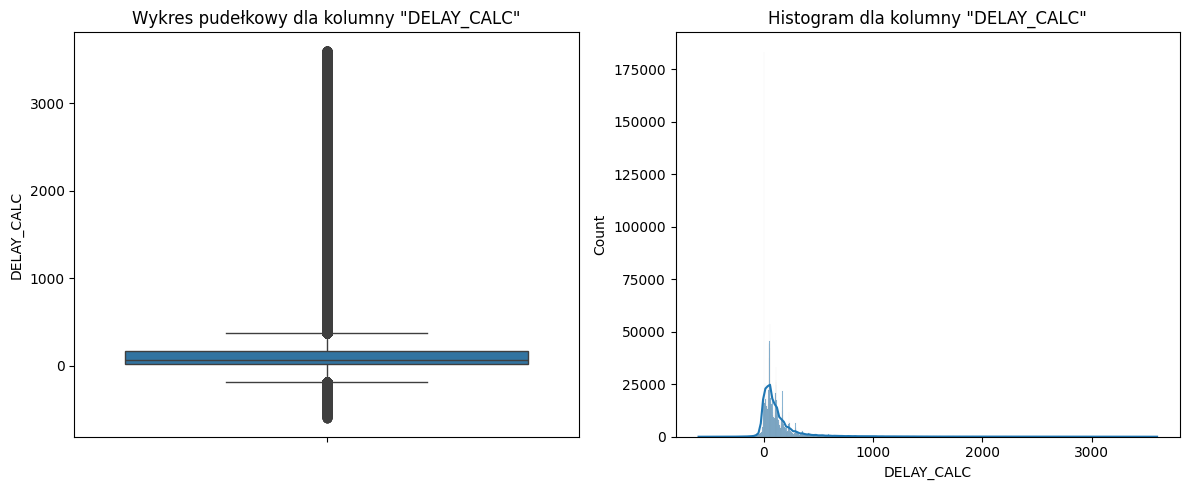

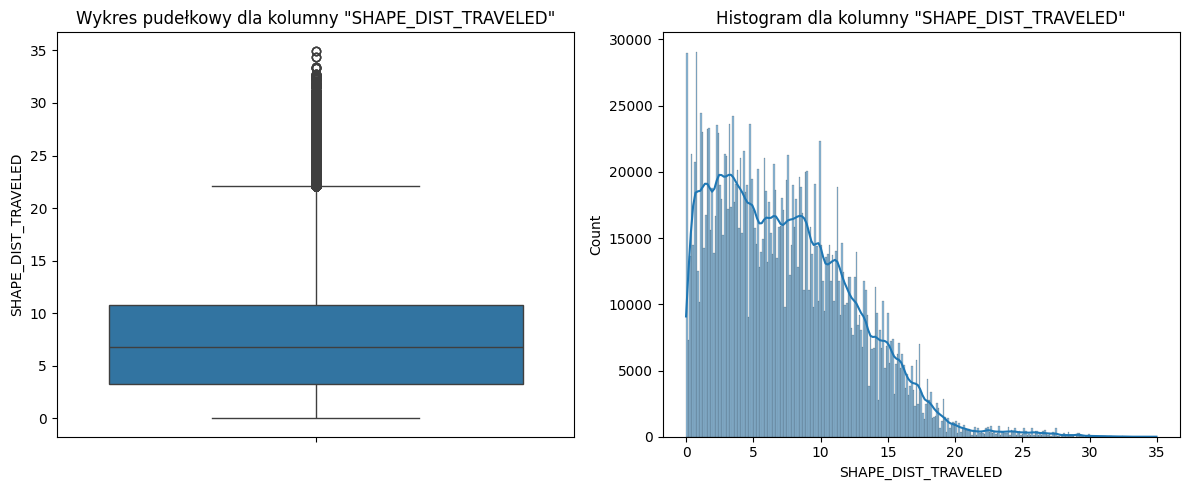

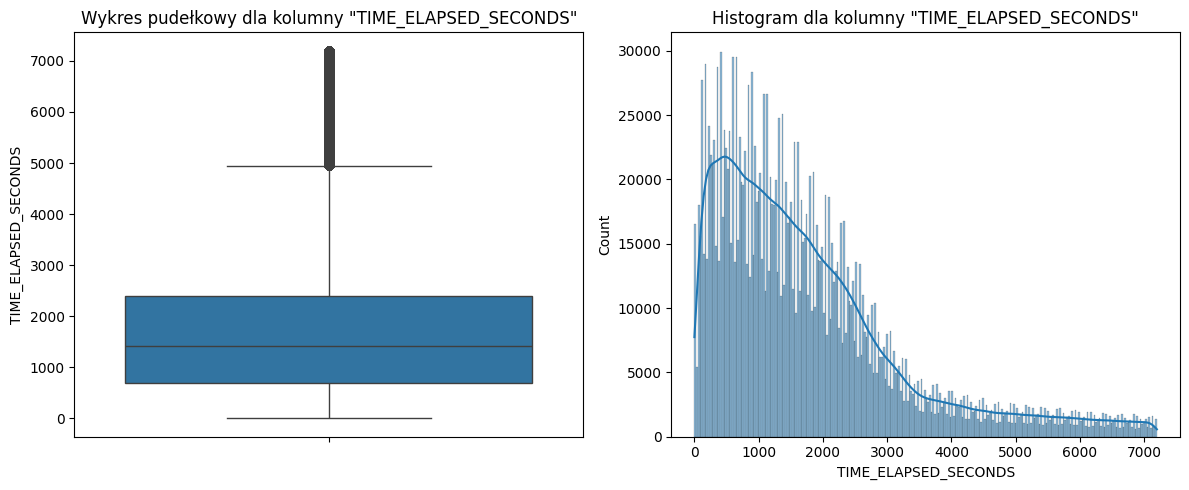

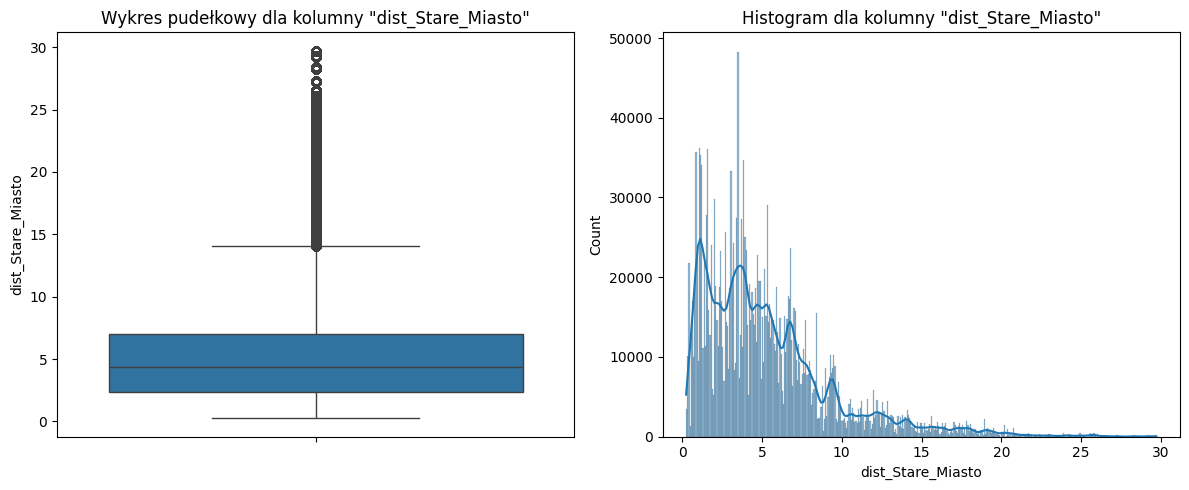

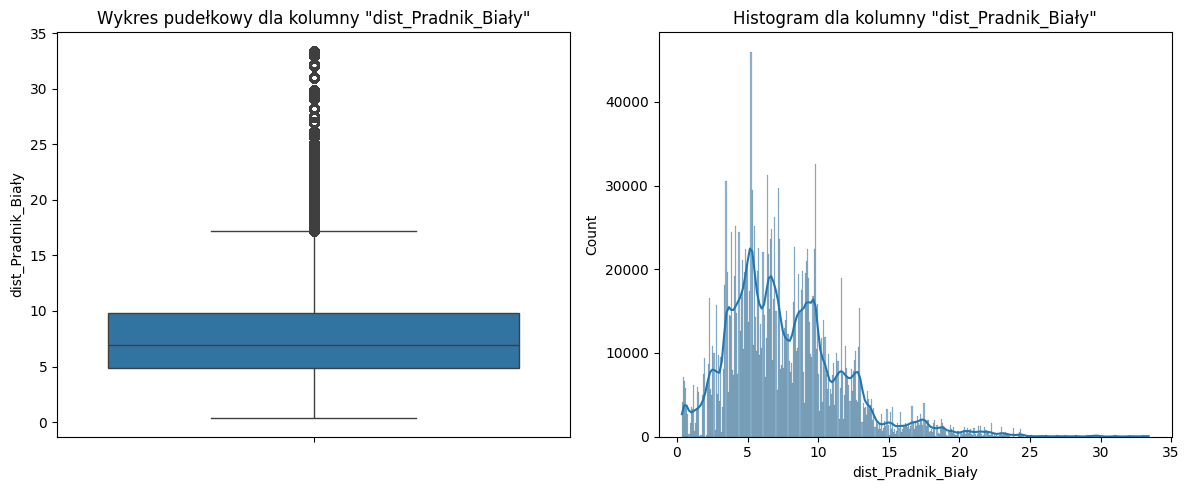

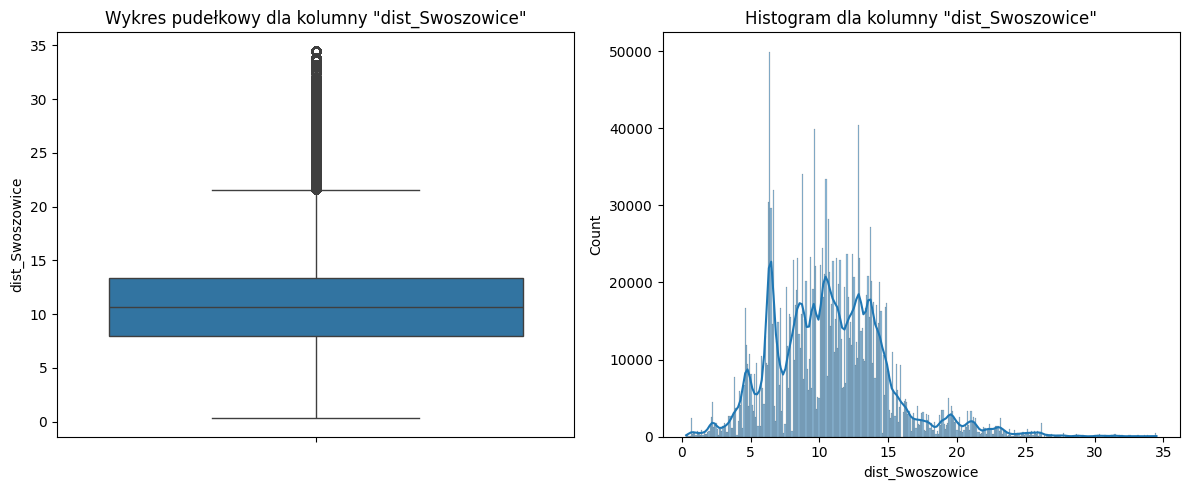

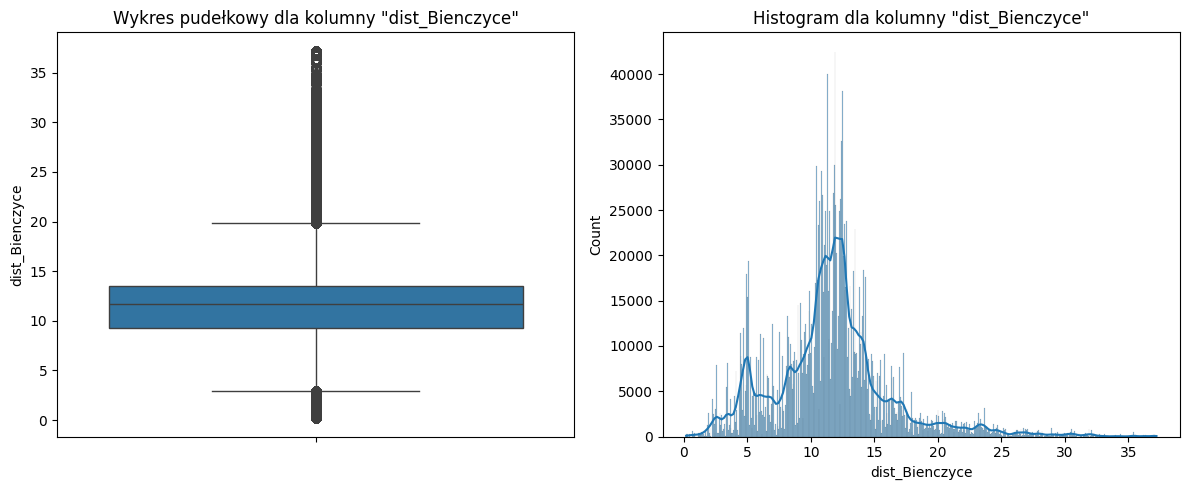

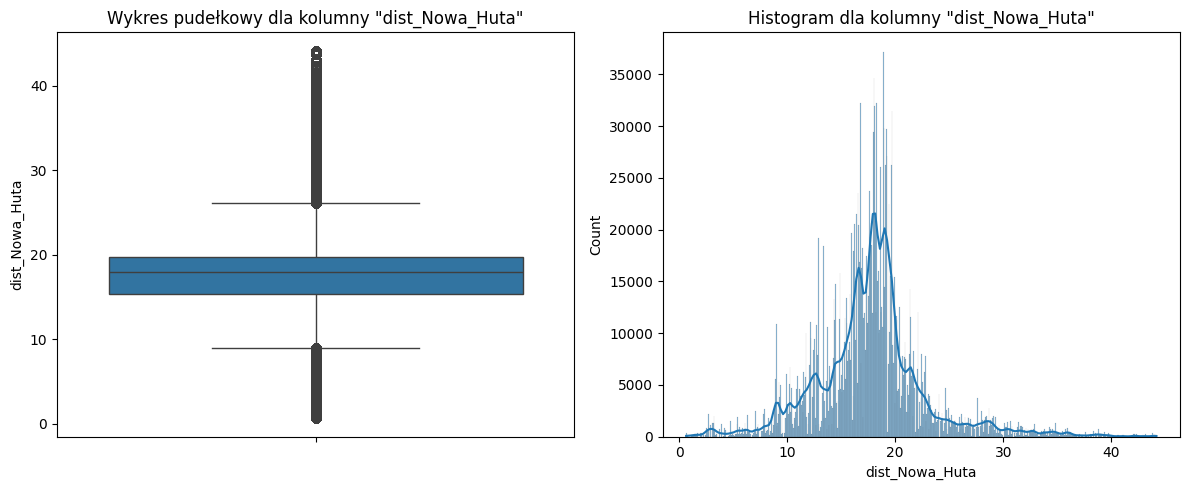

In [6]:
def plot_boxplots_and_histograms(df, features):
    for feature in features:
        plt.figure(figsize=(12, 5))

        # Boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df[feature])
        plt.title(f'Wykres pudełkowy dla kolumny "{feature}"')

        # Histogram
        plt.subplot(1, 2, 2)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Histogram dla kolumny "{feature}"')

        plt.tight_layout()
        plt.show()

plot_boxplots_and_histograms(df, [
                    'DELAY_CALC',
                    'SHAPE_DIST_TRAVELED',
                    'TIME_ELAPSED_SECONDS',
                    'dist_Stare_Miasto', 
                    'dist_Pradnik_Biały', 
                    'dist_Swoszowice', 
                    'dist_Bienczyce', 
                    'dist_Nowa_Huta'])

# Wnioski 2
### DELAY_CALC: 
* Bardzo skośny rozkład.
* Mediana blisko 0, dużo outlierów.
* Sugeruje to, że ekstremalne opóźnienia są rzadkie, ale dosyć istotne - konieczne oznaczenie

### SHAPE_DIST_TRAVELE:
* Skośny rozkład.
* Mediana ~6, IQR 3–10, Outliery >20.

### TIME_ELAPSED_SECONDS
* Silnie skośny rozkład, peak ~500–1000 s, ogon >7000 s.
* Mediana ~1300 s, IQR 400–2500 s.
* Duża zmienność, oznaczanie długich czasów przejazdu może być pomocne.

### dist_Stare_Miasto
* Rozkład bardzo skośny, peak ~0–5.
* Mediana ~5, IQR 0–15, Outliery >30.
* Duża koncentracja przystanków blisko centrum.

### dist_Pradnik_Biały
* Rozkład silnie skośny, peak ~5, długi ogon do ~35.
* Mediana ~7, IQR 4–10, dużo outlierów.

### dist_Swoszowice
* Rozkład multimodalny, występuje kilka lokalnych maksimów (~5, ~10, ~15).
* Mediana ~11, IQR 8–15, outliery >21.

### dist_Bienczyce
* Rozkład skośny prawostronnie, peak ~12.
* Mediana ~12, IQR 9–14, outliery >20 i <4.

### dist_Nowa_Huta
* Rozkład niemal symetryczny, przypomina rozkład normalny.
* Mediana ~18, IQR 14–22, Outliery >30 i <10.

In [7]:
def plot_scatterplots_for_distance_vs_delay(df, distance_columns):
    for col in distance_columns:
        plt.figure(figsize=(15, 8))
        sns.scatterplot(data=df, x='DELAY_CALC', y=col)

        plt.ylim(0, 30) 

        plt.title(f'Opóźnienie vs. Odległość do {col} (Y < 30)')
        plt.show()

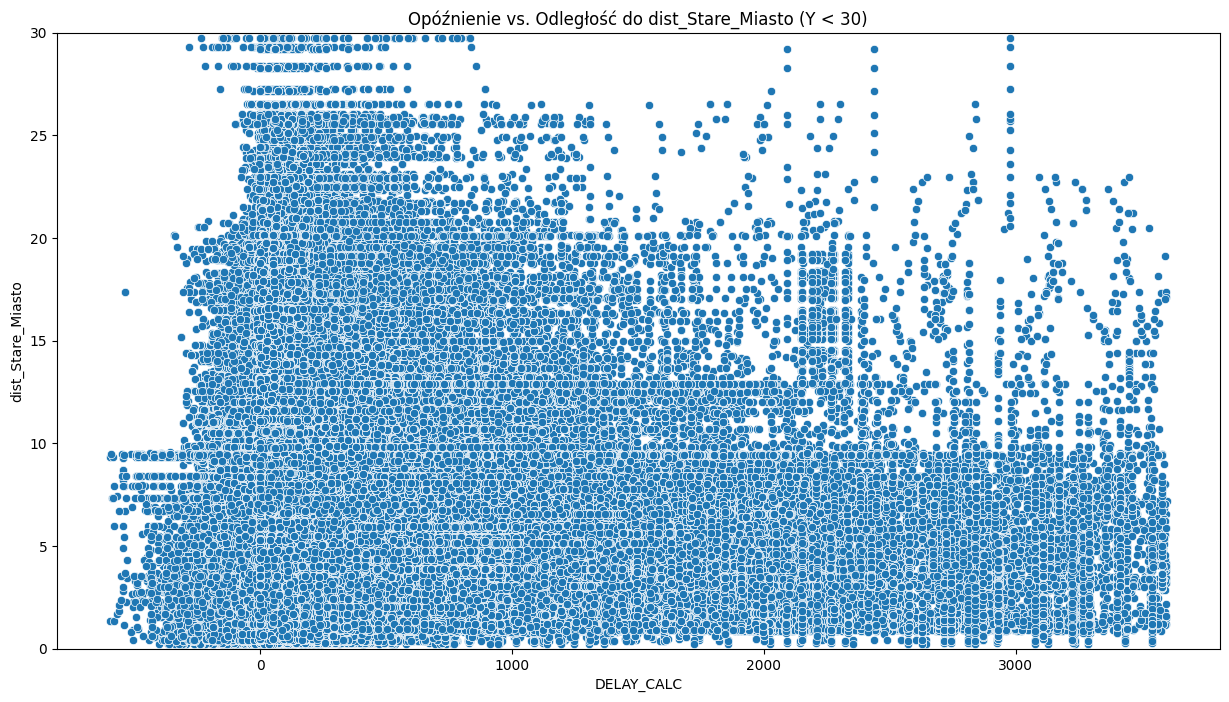

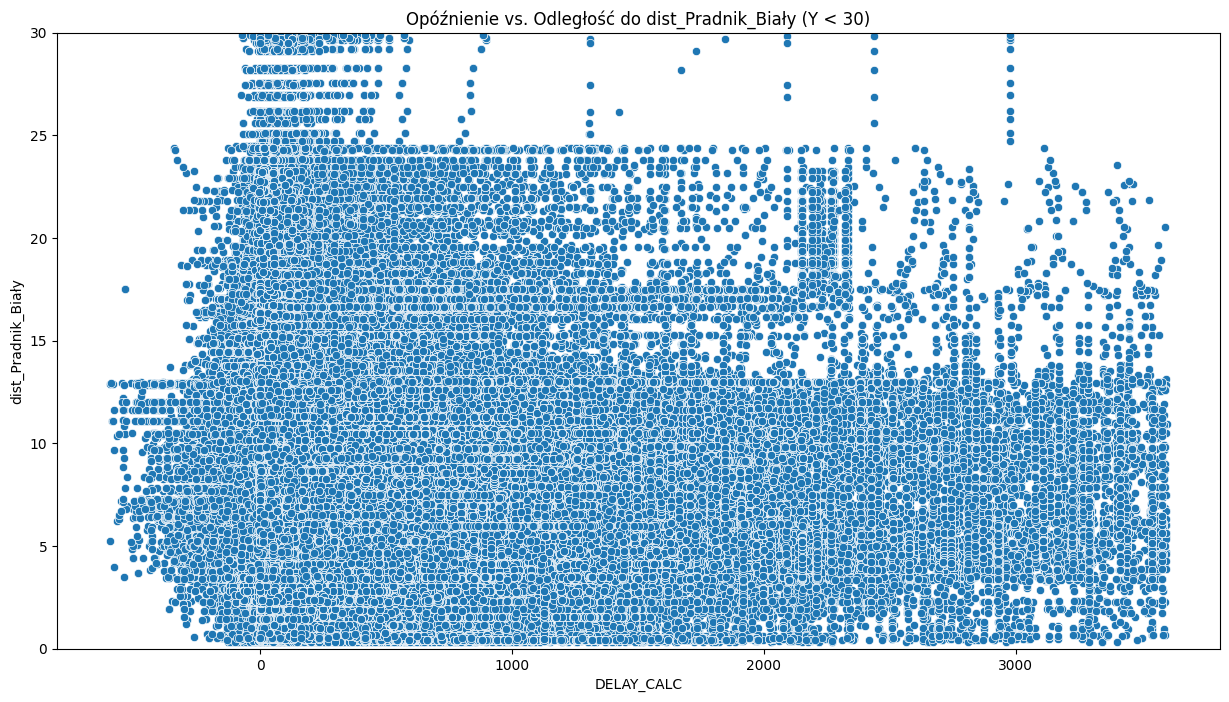

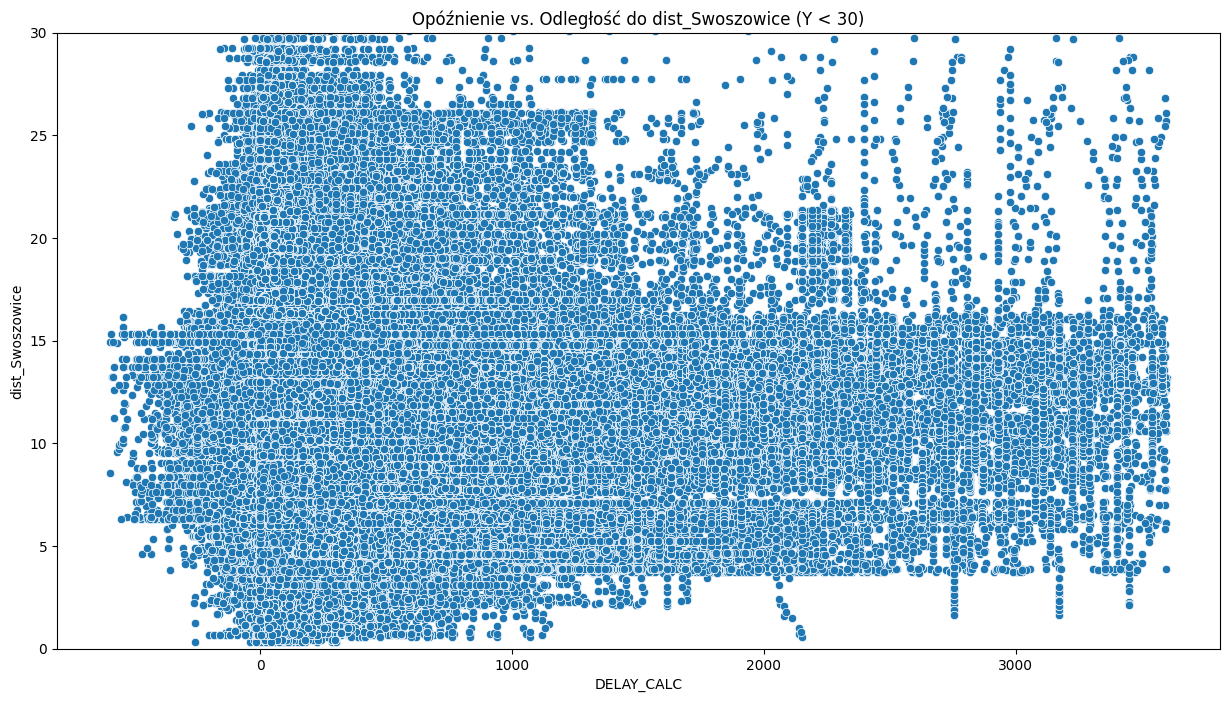

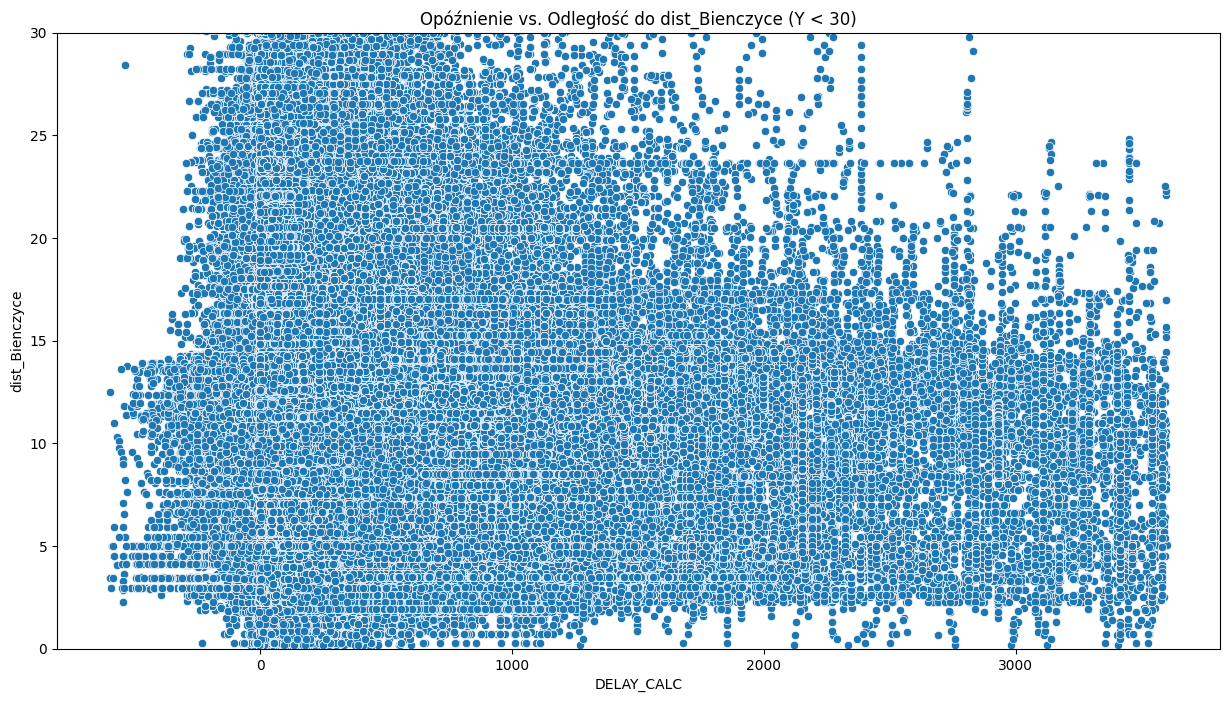

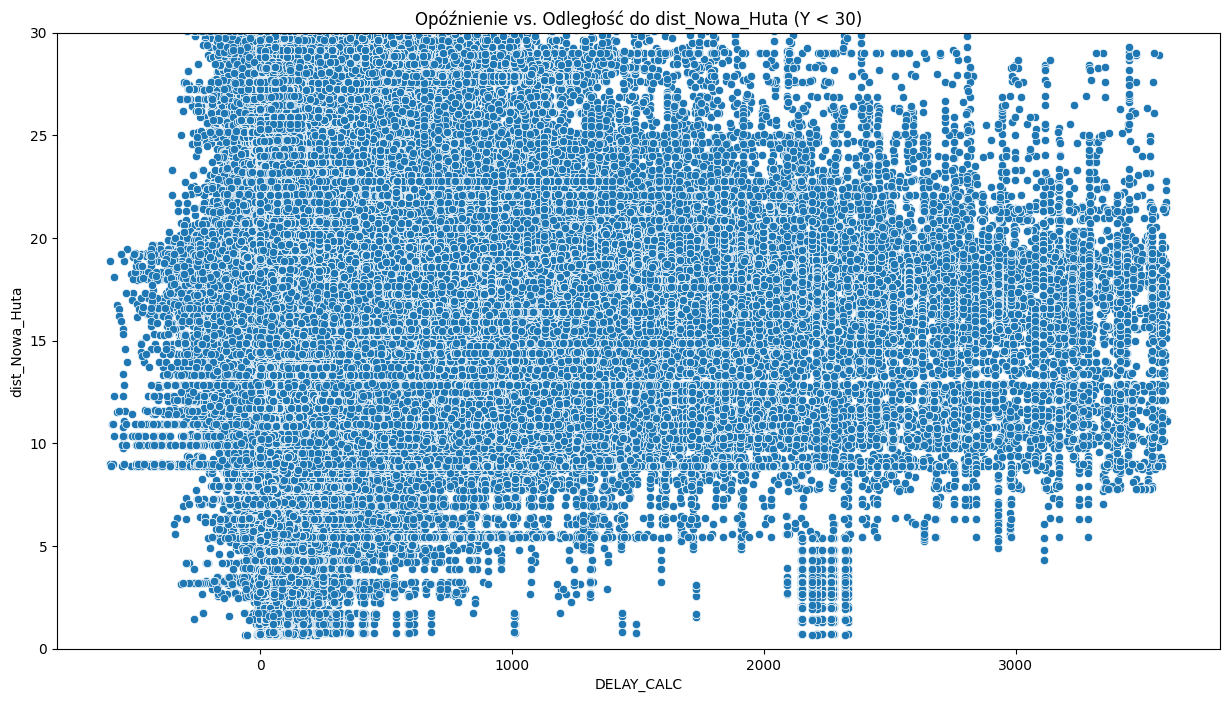

In [8]:
plot_scatterplots_for_distance_vs_delay(df, ['dist_Stare_Miasto', 'dist_Pradnik_Biały', 'dist_Swoszowice', 'dist_Bienczyce', 'dist_Nowa_Huta'])

# Wnioski 3
Wszystkie wykresy, poza ostatnim, pokazują gęste skupiska punktów w zakresie niskich opóźnień i odległości, bez wyraźnych trendów liniowych. Sugeruje to brak silnej korelacji między opóźnieniem a dystansem do konkretnych dzielnic.


In [9]:
df_max_delays= df.groupby('ROUTE_SHORT_NAME')['DELAY_CALC'].max().reset_index().sort_values(by='DELAY_CALC', ascending=False).head(10)
df_most_delayed_routes = df[df['ROUTE_SHORT_NAME'].isin(df_max_delays['ROUTE_SHORT_NAME'])]

df_mean_delays= df.groupby('ROUTE_SHORT_NAME')['DELAY_CALC'].mean().reset_index().sort_values(by='DELAY_CALC', ascending=False).head(10)
df_highest_mean_delay_routes = df[df['ROUTE_SHORT_NAME'].isin(df_mean_delays['ROUTE_SHORT_NAME'])]

df_median_delays= df.groupby('ROUTE_SHORT_NAME')['DELAY_CALC'].median().reset_index().sort_values(by='DELAY_CALC', ascending=False).head(10)
df_highest_median_delay_routes = df[df['ROUTE_SHORT_NAME'].isin(df_median_delays['ROUTE_SHORT_NAME'])]

In [10]:
def plot_boxplots_for_delays_by_route(dfs):
    for label, df in dfs.items():
        plt.figure(figsize=(12,6))
        sns.boxplot(x='ROUTE_SHORT_NAME',y='DELAY_CALC',data=df)
        plt.title(f'Wykres pudełkowy dla "{label}"')

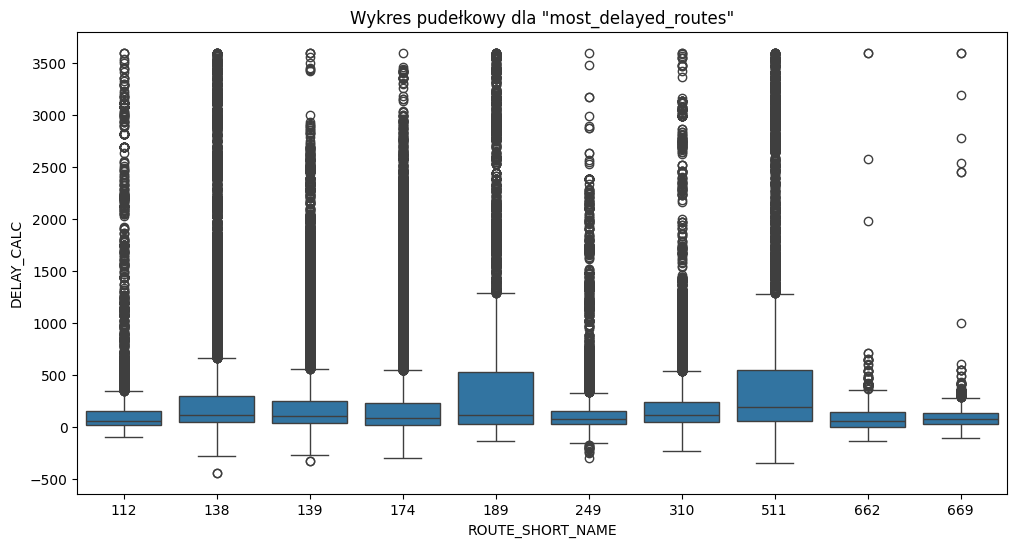

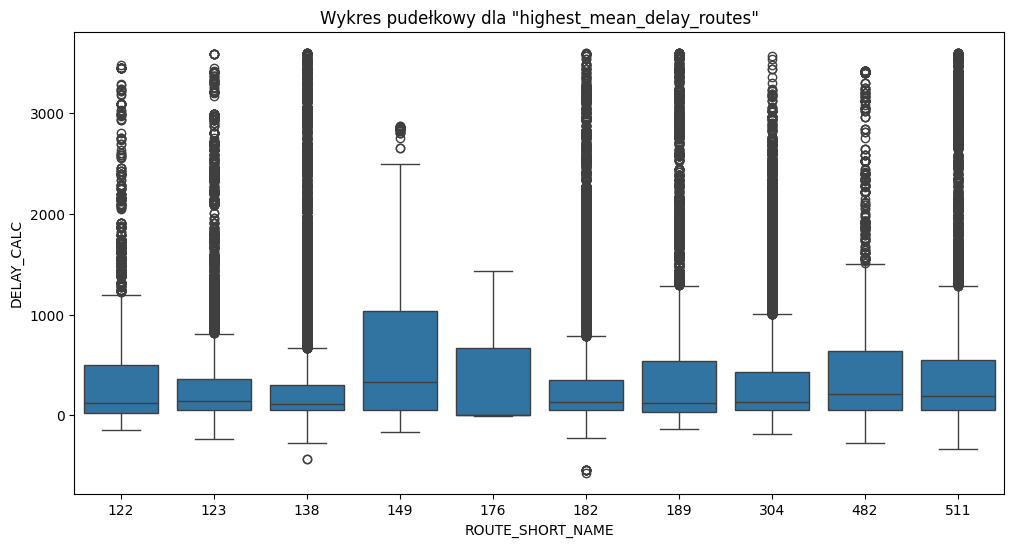

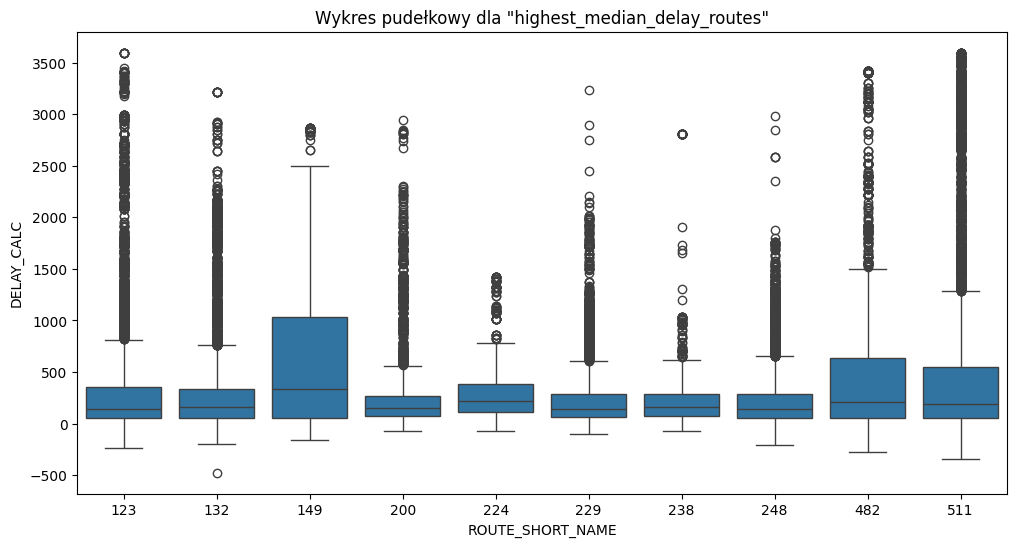

In [11]:
dfs = {'most_delayed_routes':df_most_delayed_routes, 'highest_mean_delay_routes':df_highest_mean_delay_routes, 'highest_median_delay_routes':df_highest_median_delay_routes}

plot_boxplots_for_delays_by_route(dfs)

# Wnioski 4
1. Linie o najwyższych medianach i średnich (np. 149, 482, 511):
* Linie te mają najwyższe "pudełka", co oznacza, że spóźniają się notorycznie, a nie tylko incydentalnie.
* Linia 149 wyróżnia się szerokim IQR, co sugeruje bardzo dużą nieprzewidywalność czasu przejazdu.

2. Rozkład wartości odstających (Outliers)
* Wszystkie linie wykazują długie "ogony" punktów sięgające 3600 sekund.
* Zagęszczenie punktów nad górnym wąsem (np. dla linii 138, 139, 174) wskazuje, że duże opóźnienia są zjawiskiem częstym, a nie jednostkowym.

3. Wartości ujemne (Przyspieszenia)
* Wykresy pokazują punkty poniżej 0 (np. linia 182, 132), co potwierdza problem odjazdów przed czasem dla niektórych linii (np. 662, 669).


Text(0.5, 1.0, 'Wykres słupkowy dla średniej wartości zmiennej "DELAY" w zależności od dnia tygodnia')

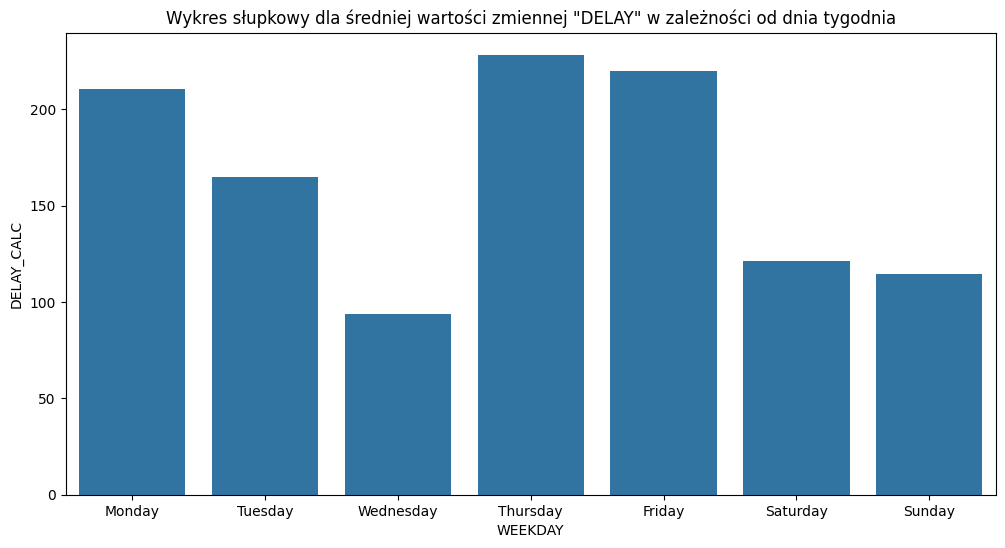

In [12]:
plt.figure(figsize=(12,6))
sns.barplot(x='WEEKDAY', y='DELAY_CALC', data=df, errorbar=None, estimator=np.mean, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title(f'Wykres słupkowy dla średniej wartości zmiennej "DELAY" w zależności od dnia tygodnia')

# Wnioski 5
* Najwyższe średnie opóźnienie występuje w czwartki, co sugeruje kumulację ruchu w tym dniu.
* Poniedziałek i piątek wykazują zbliżone, wysokie wartości, co jest typowe dla wzmożonych wyjazdów i powrotów weekendowych.
* Widoczny jest gwałtowny spadek opóźnień w środy, co może wskazywać na problem z kompletnością danych w tym konkretnym zbiorze.
* Zgodnie z oczekiwaniami, opóźnienia w weekendy są znacznie niższe ze względu na mniejsze natężenie ruchu samochodowego i brak szczytów komunikacyjnych związanych z dojazdami do pracy.

Text(0, 0.5, 'Suma opóźnienia [s]')

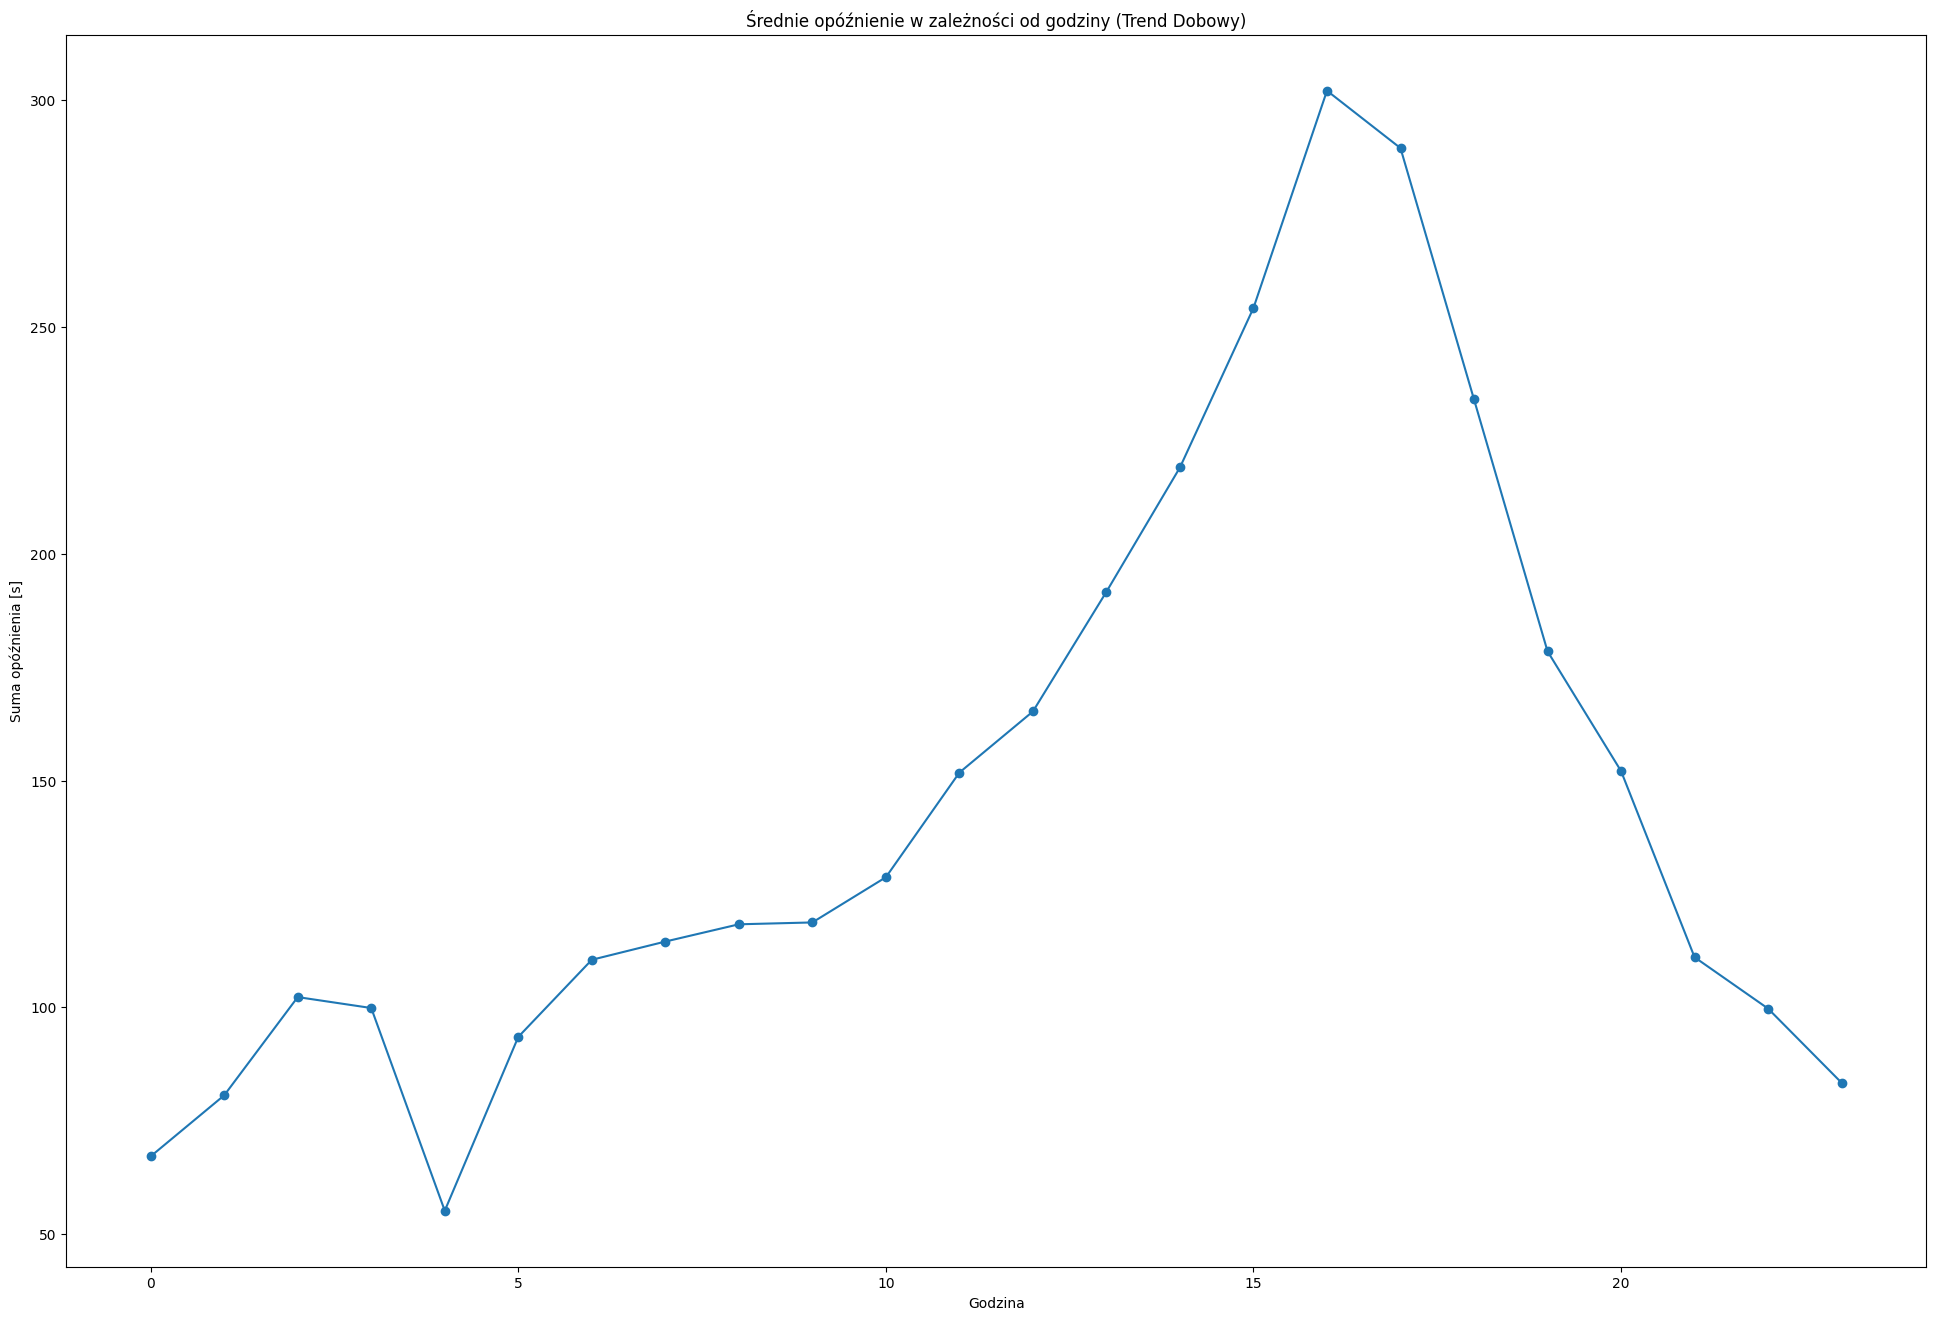

In [13]:
hourly_trend = df.groupby(df['ACTUAL_ARRIVAL'].dt.hour)['DELAY_CALC'].mean()

hourly_trend.plot(kind='line', marker='o', figsize=(24,16))
plt.title('Średnie opóźnienie w zależności od godziny (Trend Dobowy)')
plt.xlabel('Godzina')
plt.ylabel('Suma opóźnienia [s]')

# Wnioski 6
* Występowanie szczytów, popołudniowego i rannego: Najwyższe opóźnienia występują między 15:30 a 18:00, z ekstremum około godziny 17:00, co odpowiada powrotom z pracy i szkół. W przypadku szczytu porannego, jest on wyraźny, choć niższy niż popołudniowy, wzrost opóźnień przypada na godziny 07:00 – 08:30.
* Występowanie dolin komunikacyjnych: Najniższe opóźnienia występują w godzinach nocnych oraz wczesnoporannych, gdzie ruch samochodowy jest minimalny.
* Od godziny 10:00 rano opóźnienia systematycznie rosną, co sugeruje narastanie w ciągu dnia, która nie rozładowuje się aż do wieczora.

In [14]:
df['ACTUAL_ARRIVAL_ROUNDED'] = df['ACTUAL_ARRIVAL'].dt.round('30min').dt.strftime('%H:%M')

heatmap_data = df.pivot_table(values='DELAY_CALC', index='WEEKDAY', columns='ACTUAL_ARRIVAL_ROUNDED', aggfunc='mean')

heatmap_data = heatmap_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

<Axes: xlabel='WEEKDAY', ylabel='ACTUAL_ARRIVAL_ROUNDED'>

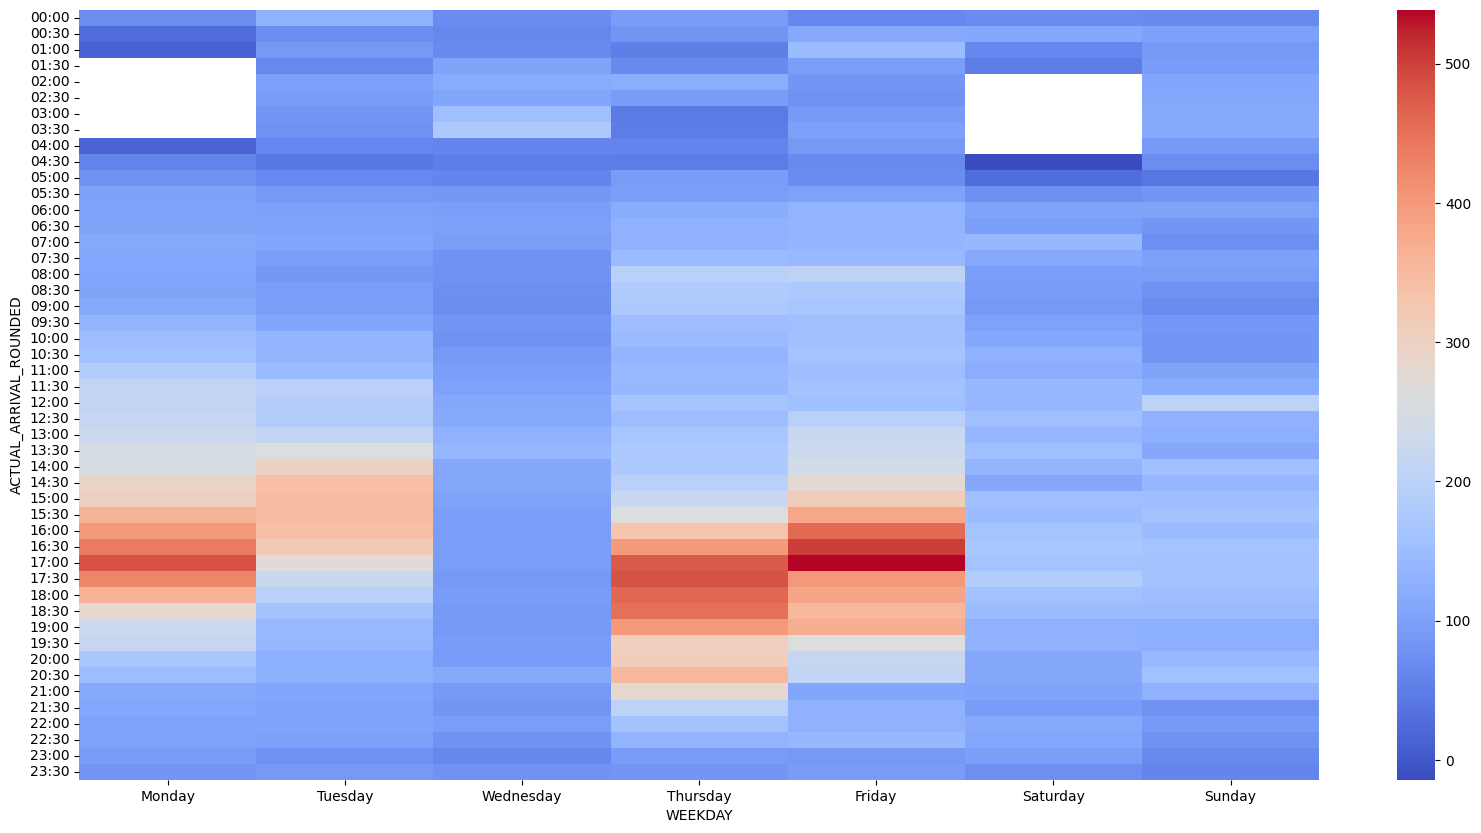

In [15]:
heatmap_data_rotated = heatmap_data.T
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data_rotated, cmap='coolwarm')

# Wnioski 7
* Największe opóźnienia występuje w czwartki między 17:00 a 18:30 oraz w poniedziałki i piątki w podobnym oknie czasowym.

* Wyraźne pasmo jasnoniebieskie/szare w godzinach 07:00 – 08:30 potwierdza mniejszą skalę problemu rano w porównaniu do popołudnia, niezależnie od dnia roboczego.

* Środa wyróżnia się niemal jednolitym kolorem niebieskim, co potwierdza wcześniejsze obserwacje o nienaturalnie niskich opóźnieniach w tym dniu. Weekendy wykazują stabilność przy niskich wartościach.

* Brak danych (białe obszary) w godzinach nocnych (01:30 – 04:00) w niektóre dni może wynikać z przerw w kursowaniu linii nocnych lub braku odczytów w tym czasie.

Text(0.5, 1.0, 'Spaghetti plot dla trasy 304 pokazujący opóźnienia na poszczególnych przystankach')

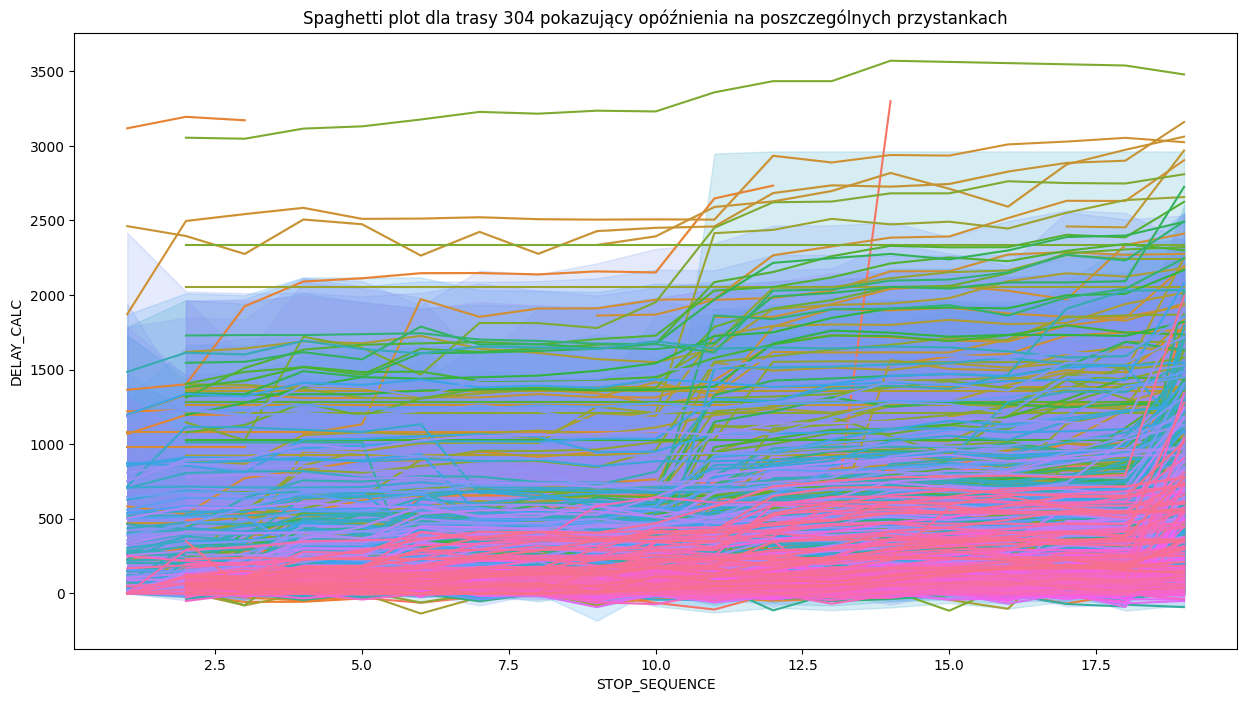

In [16]:
df_route_304 = df[df['ROUTE_SHORT_NAME'] == 304]

plt.figure(figsize=(15,8))
sns.lineplot(data=df_route_304, x='STOP_SEQUENCE', y='DELAY_CALC', hue='TRIP_ID', legend=None)
plt.title('Spaghetti plot dla trasy 304 pokazujący opóźnienia na poszczególnych przystankach')


# Wnioski 8

* Linia wykazuje trend wzrostowy w miarę pokonywania trasy, co oznacza, że raz złapane opóźnienie jest trudne do nadrobienia i ma tendencję do narastania.

* W okolicach 10 przystanku w sekwencji widoczny jest gwałtowny skok opóźnienia dla wielu kursów, szczególnie tych o wysokim opóźnieniu początkowym, co sugeruje istnienie zatorów w tej konkretnej lokalizacji.

* Występuje duża rozpiętość opóźnień. Część kursów oscyluje wokół 0 s, inne startują już z opóźnieniem 1500–2000 s lub gwałtownie do niego dociągają, co wskazuje na niestabilność punktualności w zależności od godziny.

* Niektóre kursy pokazują, że na pewnych odcinkach kierowcy są w stanie nadrobić część strat czasowych.

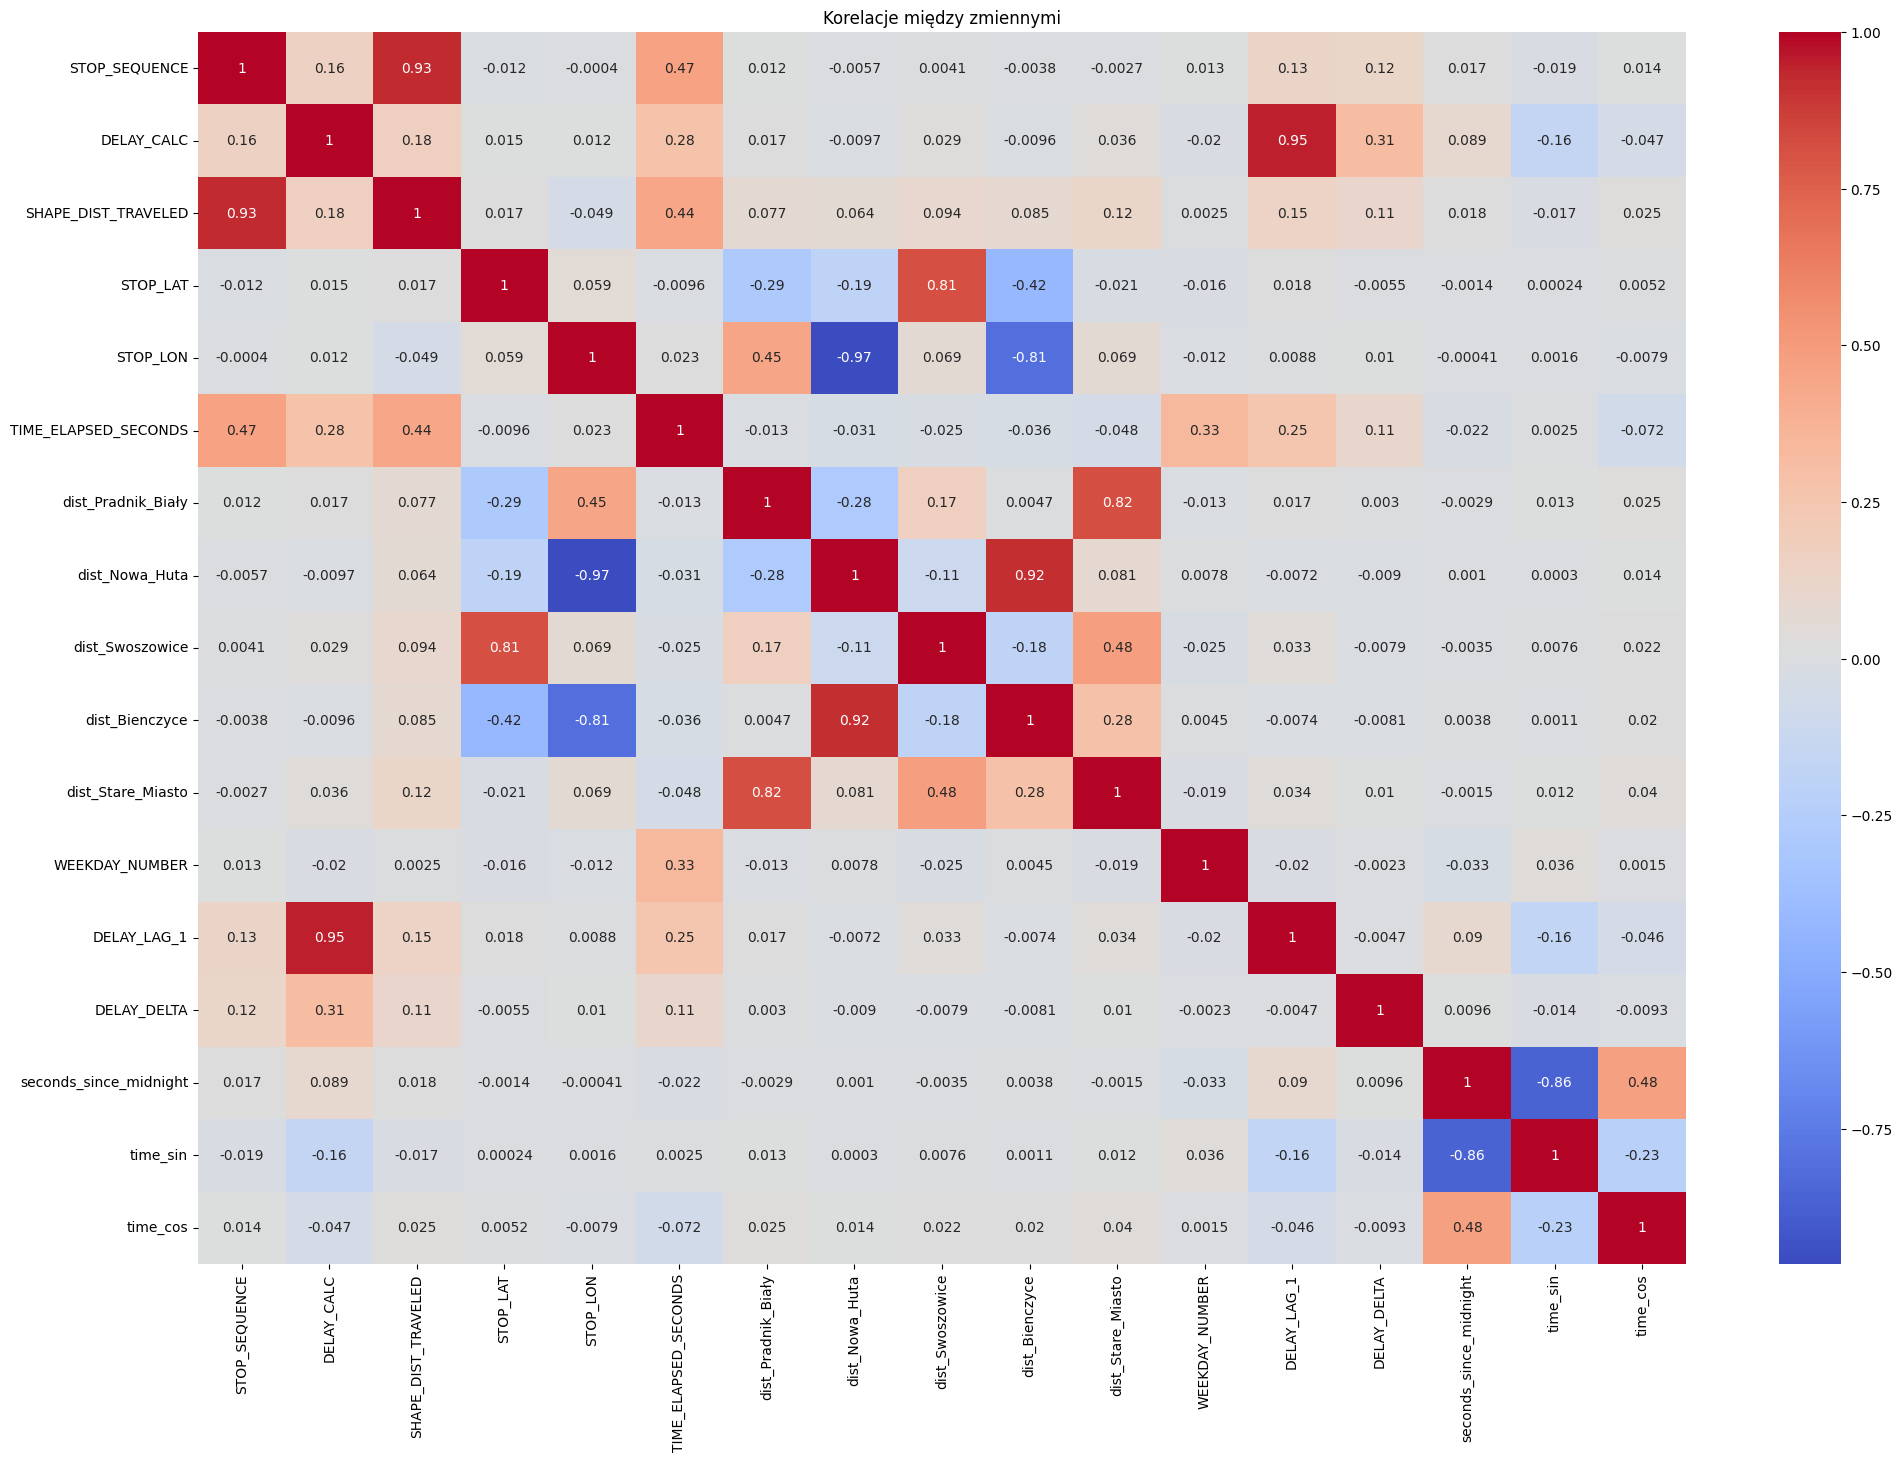

In [17]:
df['WEEKDAY_NUMBER'] = df['ACTUAL_ARRIVAL'].dt.weekday

num_features = df[[
    'STOP_SEQUENCE', 
    'DELAY_CALC',
    'SHAPE_DIST_TRAVELED',
    'STOP_LAT',
    'STOP_LON',
    'TIME_ELAPSED_SECONDS',
    'dist_Pradnik_Biały',
    'dist_Nowa_Huta',
    'dist_Swoszowice',
    'dist_Bienczyce',
    'dist_Stare_Miasto',
    'WEEKDAY_NUMBER',
    'DELAY_LAG_1',
    'DELAY_DELTA',
    'seconds_since_midnight',
    'time_sin',
    'time_cos',
]]

plt.figure(figsize=(24, 16))
sns.heatmap(num_features.corr(), annot=True, cmap='coolwarm')
plt.title('Korelacje między zmiennymi')
plt.show()

# Wnioski 9

1. Najsilniejsza korelacja dodatnia występuje między DELAY_CALC a DELAY_LAG_1, co potwierdza, że obecne opóźnienie jest niemal całkowicie zdeterminowane przez stan w poprzednim kroku czasowym.

2. Korelacja DELAY_CALC z DELAY_DELTA (0,31) wskazuje, że dynamika zmian ma istotny, choć mniejszy wpływ na wynik końcowy niż sama inercja szeregu.

3. Bardzo wysoka korelacja (0,92) między STOP_SEQUENCE a SHAPE_DIST_TRAVELED jest naturalna – im dalszy przystanek na trasie, tym większy przebyty dystans.

4. Silne korelacje ujemne (np. -0,97 między dist_Nowa_Huta a STOP_LON) wynikają z geograficznego układu dzielnic Krakowa i są cechami stałymi.

3. Korelacja DELAY_CALC z przebytym dystansem oraz czasem przejazdu jest niska. Oznacza to, że same kilometry nie generują opóźnień liniowo, lecz zależą one od czynników zewnętrznych (korki, dzień tygodnia).

4. Niskie wartości dla time_sin i time_cos sugerują, że wpływ godziny na opóźnienie jest nieliniowy i wymaga modeli zdolnych do wychwytywania złożonych interakcji.

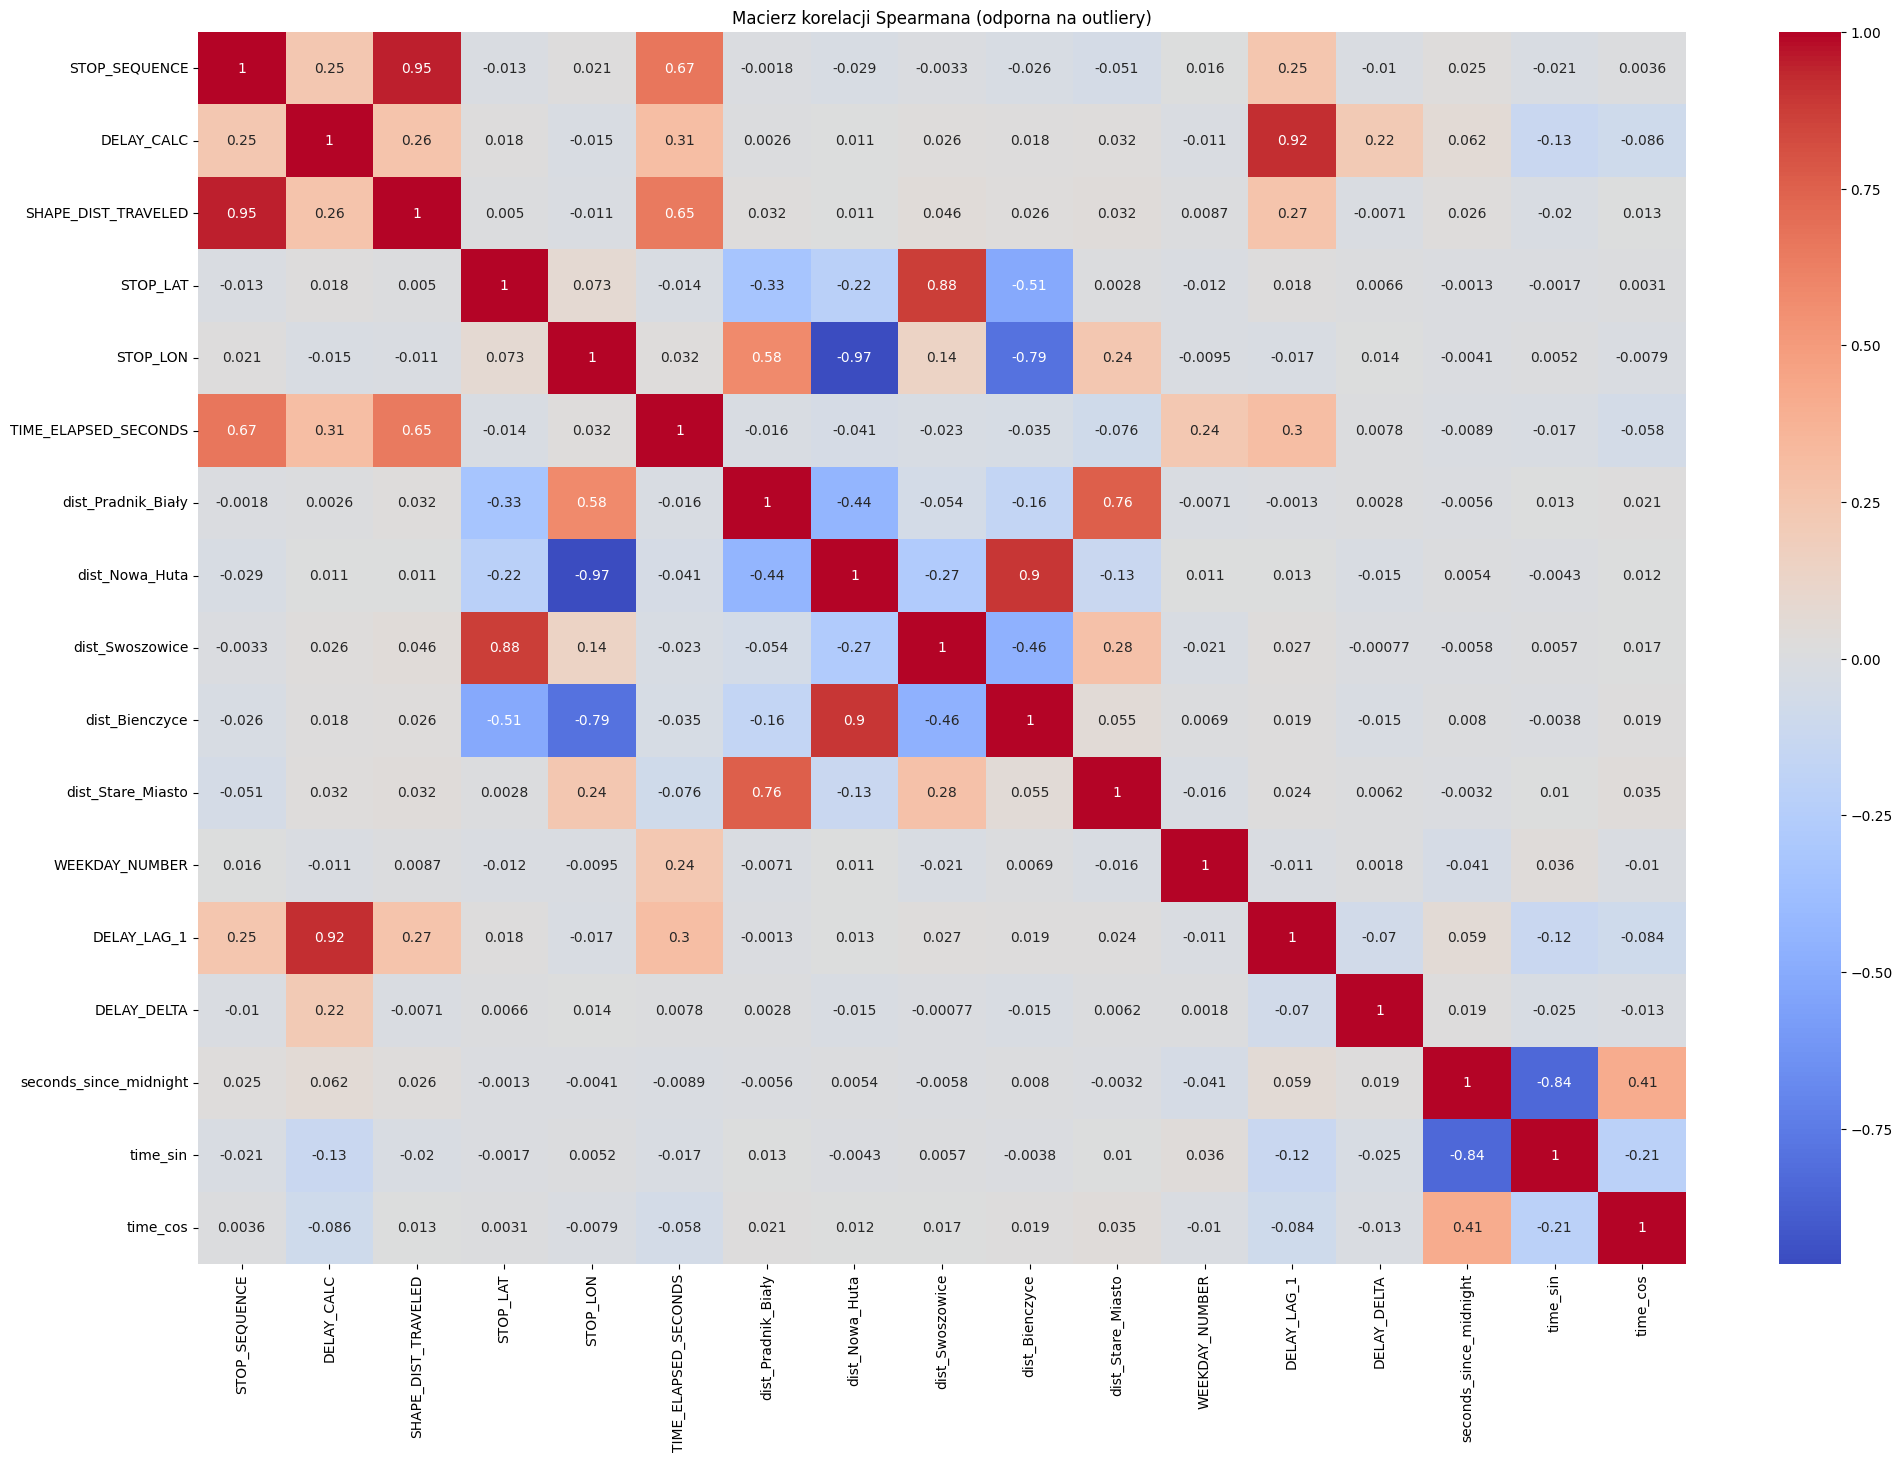

In [18]:
spearman_matrix = num_features.corr(method='spearman')

plt.figure(figsize=(24, 16))
sns.heatmap(spearman_matrix, annot=True, cmap='coolwarm')
plt.title("Macierz korelacji Spearmana (odporna na outliery)")
plt.show()

# Wnioski 10

Macierz korelacji Spearmana dostarcza dowodu na to, jak dane są odporne na proste, liniowe modele. 

1. Korelacja DELAY_LAG_1 ze zmienną celu DELAY_CALC spadła z 0.95 (Pearson) na 0.92 (Spearman). To wciąż gigantyczna wartość, która krzyczy: "jeśli mnie zostawisz, model nie nauczy się niczego o korkach, tylko będzie przepisywał wynik z poprzedniego przystanku".

2. Korelacja STOP_SEQUENCE wzrosła z 0.16 do 0.25. To oznacza, że wraz z kolejnymi przystankami opóźnienie rośnie w sposób nieliniowy (np. gwałtownie w centrum).

4. TIME_ELAPSED_SECONDS: Wzrost z 0.26 do 0.30. Czas spędzony w trasie jest lepszym predyktorem opóźnień niż czyste kilometry.

3. Korelacje między współrzędnymi a dystansami do dzielnic pozostały identyczne. To potwierdza, że te zmienne są ze sobą sztywno powiązane geometrycznie.

4. WEEKDAY_NUMBER nadal wykazuje korelację bliską zeru (Co nie oznacza, że dzień tygodnia nie jest ważny. To oznacza jedynie, że nie ma monotonicznego związku.)

In [19]:
from scipy.stats import kruskal

features = df.columns.tolist()

for feature in features:
    groups = [group["DELAY_CALC"].dropna() for name, group in df.groupby(feature)]
    H, p = kruskal(*groups)

    print(f"\nAnaliza wariancji dla cechy: {feature}")
    print(f"Kruskal-Wallis H={H:.2f}, p-value={p:.4f}")
    if p < 0.05:
        print(f"Istnieje istotna różnica w opóźnieniach między grupami cechy {feature}.")


Analiza wariancji dla cechy: UNIQUE_TRIP_KEY
Kruskal-Wallis H=1221027.65, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy UNIQUE_TRIP_KEY.

Analiza wariancji dla cechy: TRIP_ID
Kruskal-Wallis H=928806.69, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy TRIP_ID.

Analiza wariancji dla cechy: TRIP_HEADSIGN
Kruskal-Wallis H=110030.17, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy TRIP_HEADSIGN.

Analiza wariancji dla cechy: ROUTE_SHORT_NAME
Kruskal-Wallis H=119446.46, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy ROUTE_SHORT_NAME.

Analiza wariancji dla cechy: MODE
Kruskal-Wallis H=50019.86, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy MODE.

Analiza wariancji dla cechy: STOP_ID
Kruskal-Wallis H=327345.00, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy STOP_ID.

Analiza wariancji dla cechy: STOP_NAME
Kruskal-Wallis

# Wnioski 11 

1. Dzień tygodnia i Czas (Zmienne cykliczne), mimo że korelacja Spearmana dla WEEKDAY_NUMBER była bliska zeru, test Kruskala-Wallisa wykazuje, że dni tygodnia nie są sobie równe. Rozkłady opóźnień w czwartki różnią się od tych w niedziele w sposób, który nie jest przypadkowy. 
2. Wysokie wartości dla time_sin i time_cos potwierdzają, że pora dnia to ważny predyktor.
3. Wysokie wartości dla TRIP_ID sugerują, że konkretne kursy o konkretnych godzinach mają swoją bardzo powtarzalną charakterystykę opóźnień. (model będzie w stanie nauczyć się, że np. przejazd autbusu 304 o 7:15 rano ma inny profil ryzyka niż inny przejazd).
4. Wszystkie dystanse do dzielnic oraz dane o przystankach mają niemal identyczne, wysokie wartości statystyki H .Potwierdza to, że lokalizacja pojazdu jest jednym z ważniejszych cech, determinujących opóźnienie.

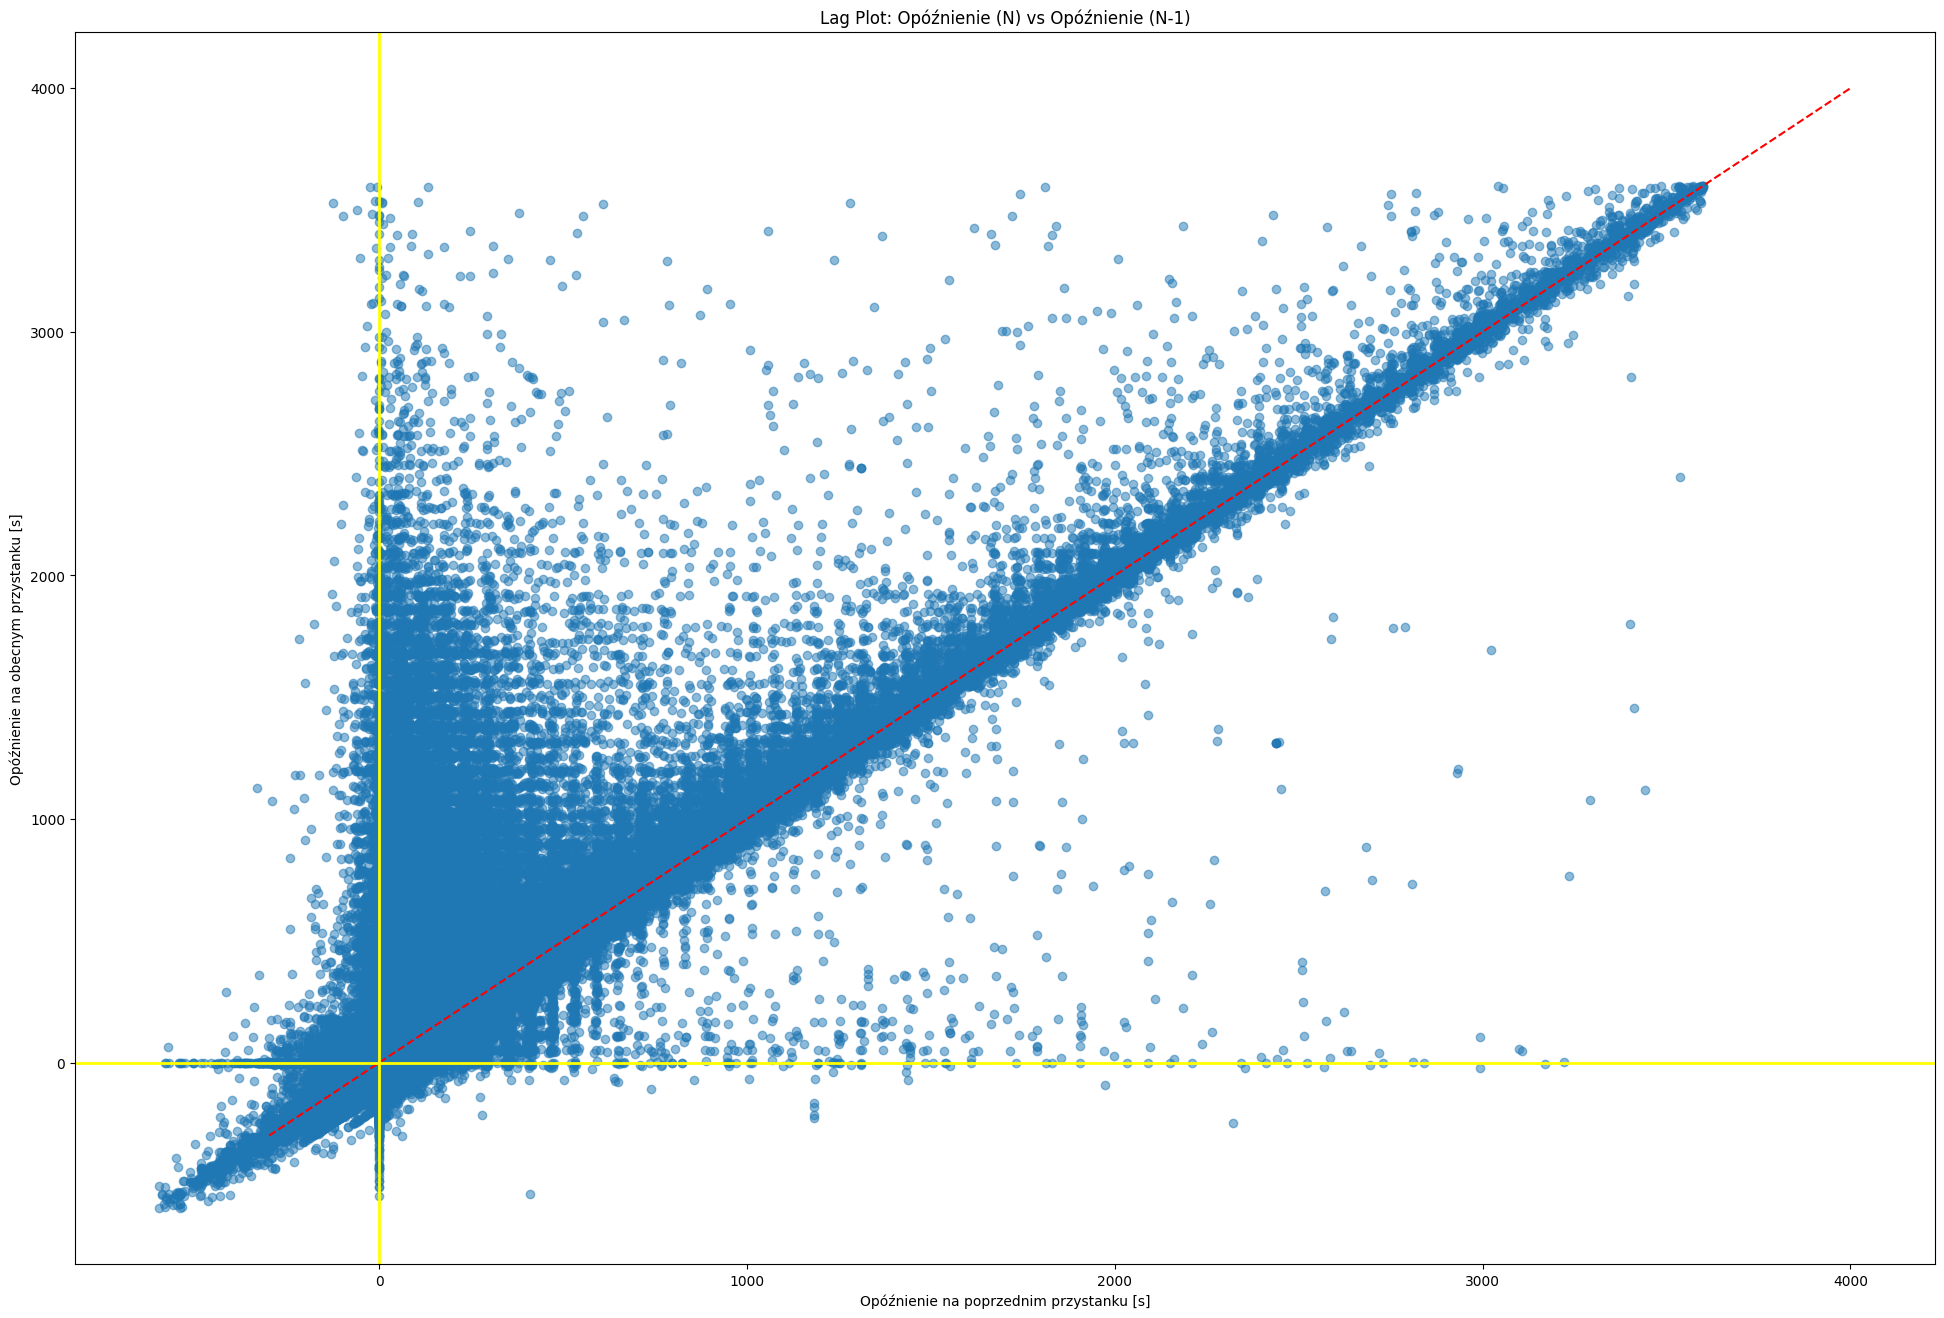

In [20]:
plt.figure(figsize=(24, 16))
plt.scatter(df['DELAY_LAG_1'], df['DELAY_CALC'], alpha=0.5)
plt.plot([-300, 4000], [-300, 4000], color='red', linestyle='--') # linia idealnej korelacji
plt.axhline(0, color='yellow', linewidth=2) # linia pionowa na x=0 
plt.axvline(0, color='yellow', linewidth=2)
plt.title('Lag Plot: Opóźnienie (N) vs Opóźnienie (N-1)')
plt.xlabel('Opóźnienie na poprzednim przystanku [s]')
plt.ylabel('Opóźnienie na obecnym przystanku [s]')
plt.show()

# Wnioski 12
* Większość punktów skupia się wzdłuż czerwonej linii przerywanej, co oznacza, że opóźnienie na obecnym przystanku jest niemal identyczne jak na poprzednim.Potwierdza to korelację na poziomie 0,95 i wysoką inercję systemu.

* Punkty powyżej linii reprezentują sytuacje, w których opóźnienie wzrosło między przystankami. Punkty poniżej linii pokazują przypadki nadrabiania czasu przez kierowców. Największe rozproszenie występuje przy niskich wartościach opóźnienia, co oznacza, że małe opóźnienia są bardziej nieprzewidywalne niż te duże.

* Skupisko punktów ujemnych w lewym, dolnym rogu potwierdza, że pojazdy jadące przed czasem mają tendencję do utrzymywania tego stanu na kolejnych przystankach.

Text(0.5, 1.0, 'Trend opóźnień w czasie (30-min Moving Average)')

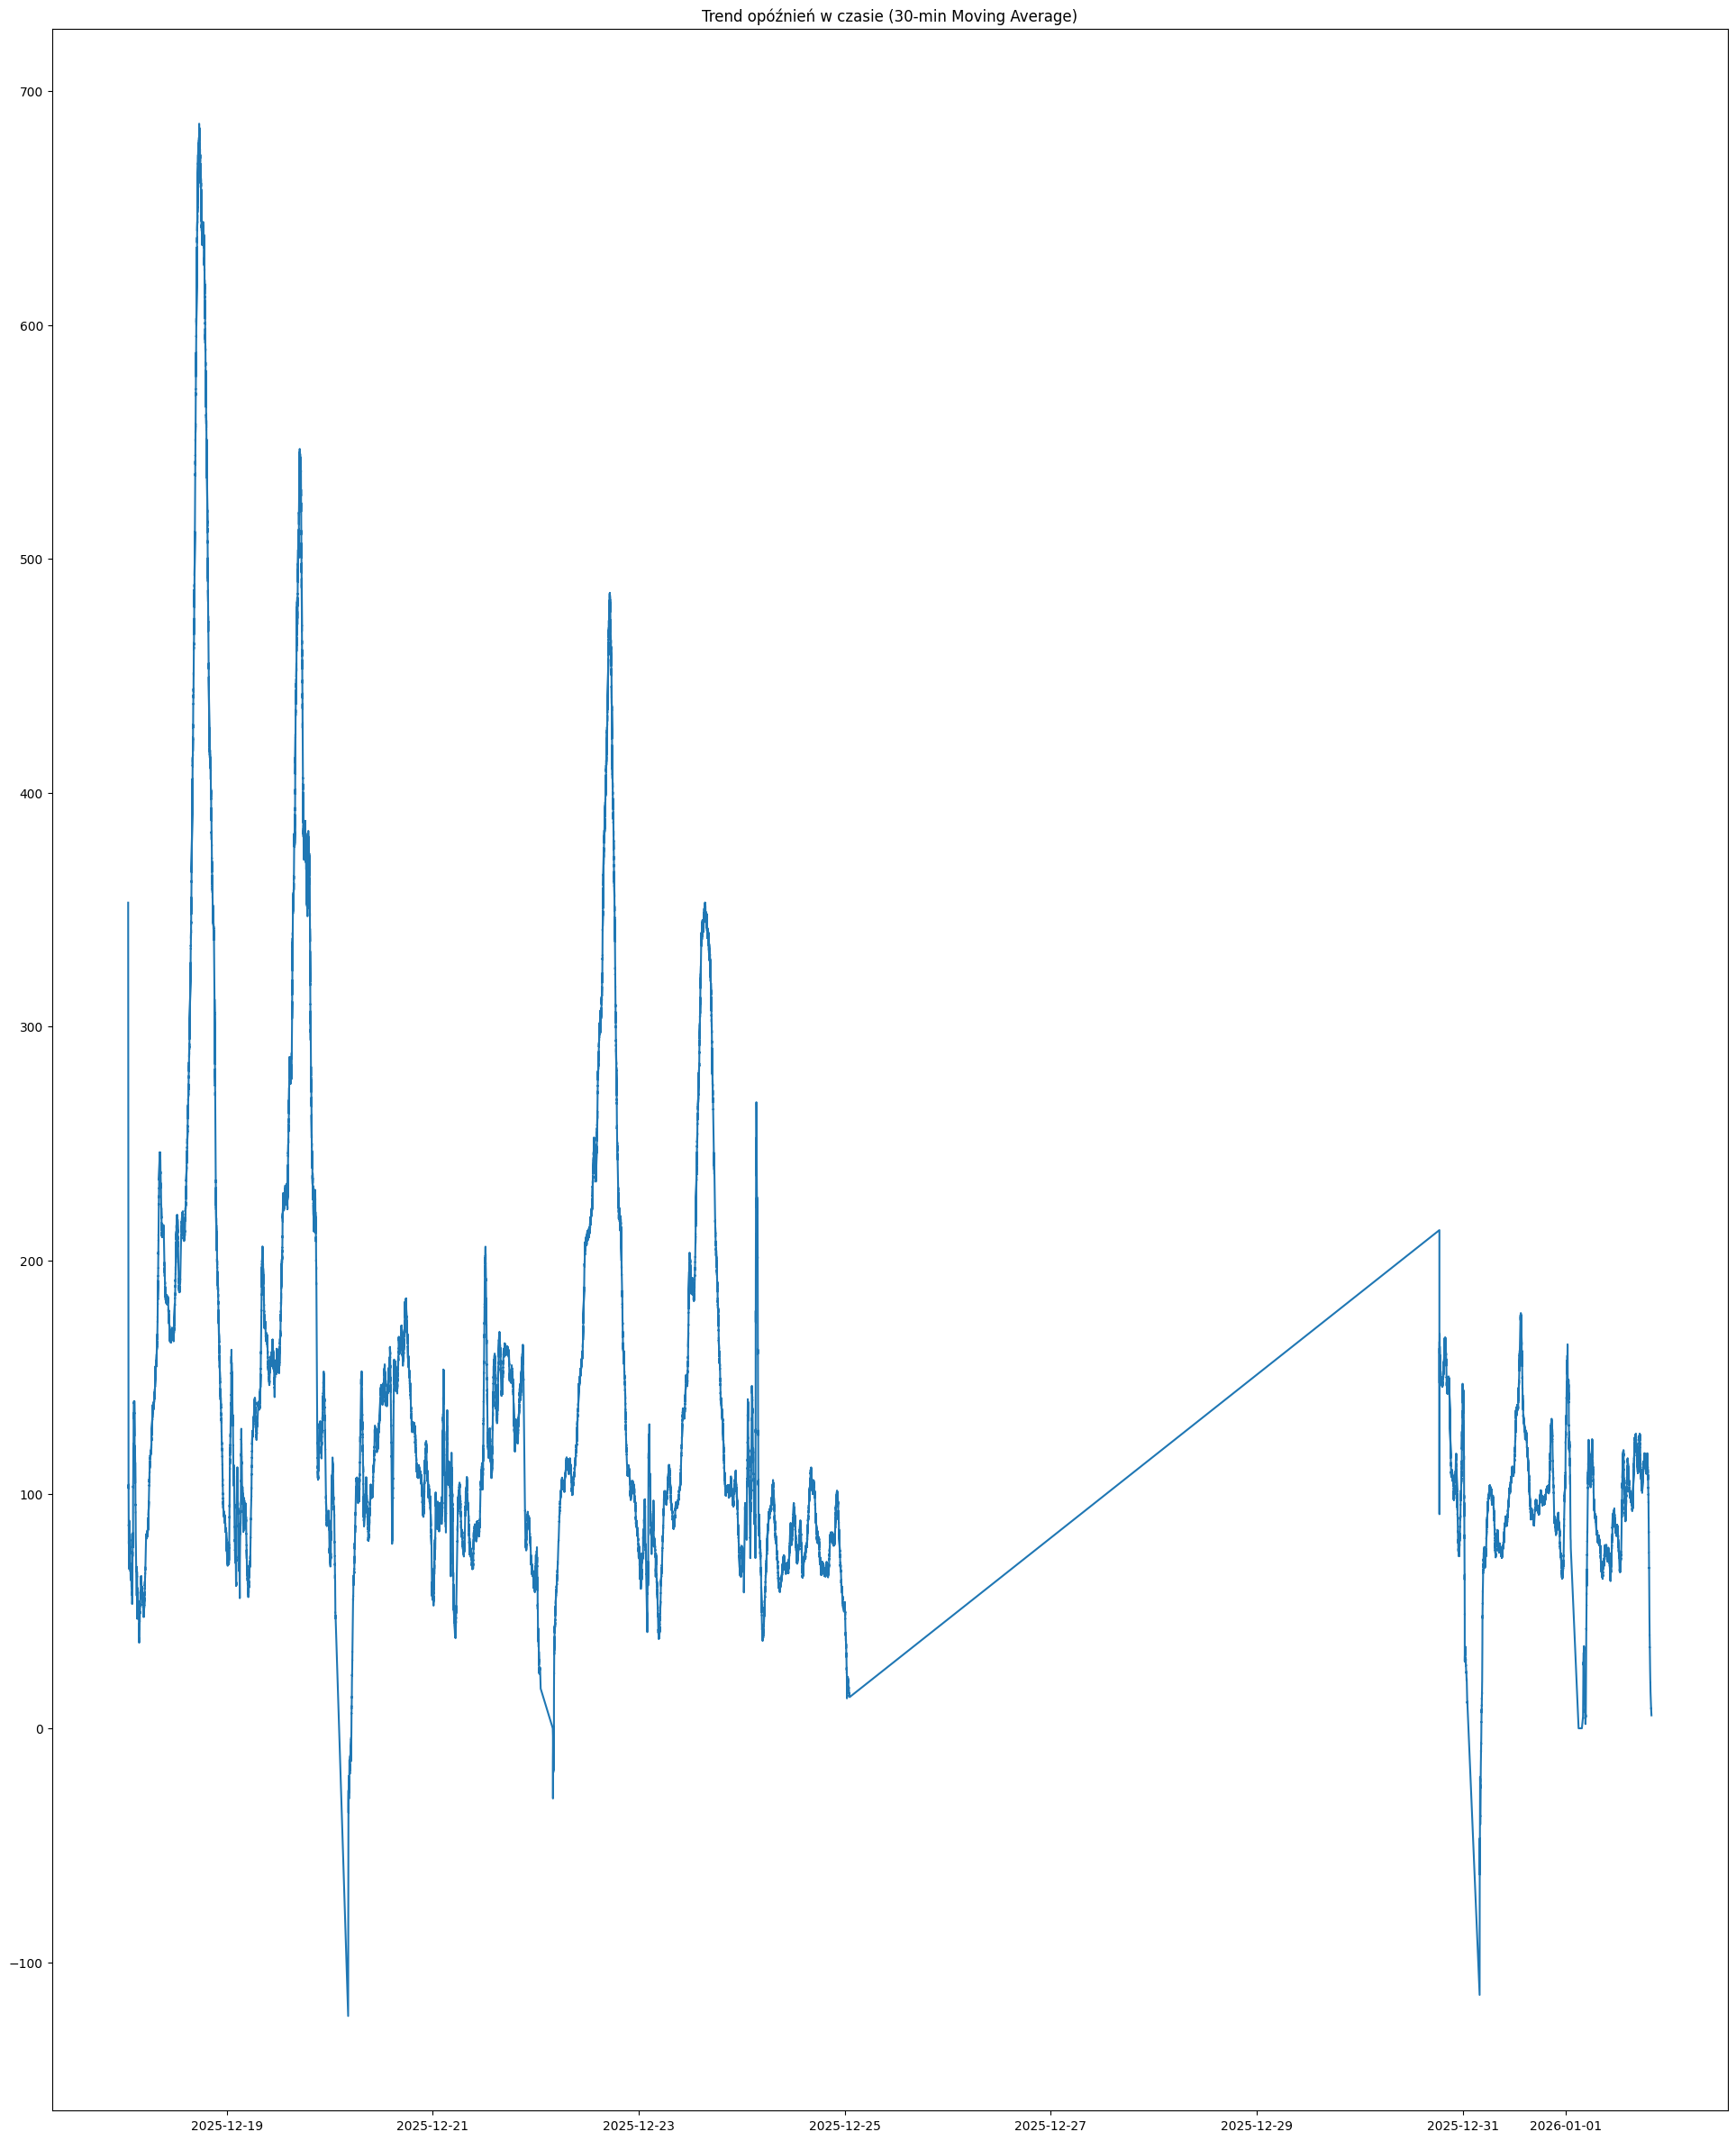

In [21]:
df_trend = df.set_index('ACTUAL_ARRIVAL').sort_index()
df_trend['moving_avg'] = df_trend['DELAY_CALC'].rolling(window='30min').mean()

plt.figure(figsize=(24, 30))
plt.plot(df_trend.index, df_trend['moving_avg'])
plt.title('Trend opóźnień w czasie (30-min Moving Average)')

# Wnioski 13

1. Wykres pokazuje cykliczne peaki opóźnień, które odpowiadają popołudniowym szczytom komunikacyjnym widocznym na poprzednich analizach.
Amplituda tych pików jest zmienna, niektóre dni generują ekstremalne wartości, inne są znacznie łagodniejsze.

2. Płaska linia między 25 a 30 grudnia wskazuje na brak danych w tym okresie lub drastyczne ograniczenie kursowania, co jest typowe dla okresu Bożego Narodzenia.

3. Gwałtowne zejścia wykresu poniżej zera (np. ok. 19 grudnia) potwierdzają występowanie serii kursów przyspieszonych względem rozkładu.

4. Wariancja opóźnień nie jest stała, okresy wysokich opóźnień charakteryzują się znacznie większymi wahaniami niż okresy stabilne (np. nocne). Sugeruje to konieczność użycia modeli radzących sobie ze zmienną wariancją lub zastosowania transformacji stabilizujących przed modelowaniem.

<Axes: title={'center': 'Narastanie opóźnienia wzdłuż trasy'}, xlabel='STOP_SEQUENCE'>

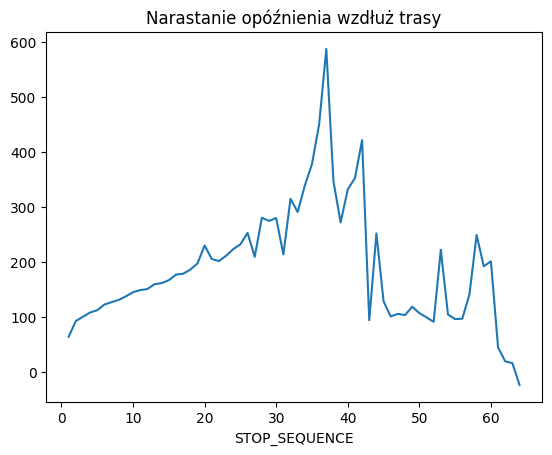

In [22]:
stop_trend = df.groupby('STOP_SEQUENCE')['DELAY_CALC'].mean()
stop_trend.plot(title='Narastanie opóźnienia wzdłuż trasy')

# Wnioski 14

* Do około 37. przystanku widoczny jest stały, prawie liniowy wzrost średniego opóźnienia z ok. 60 s do poziomu 600 s.

* Gwałtowny skok między 30 a 37 przystankiem sugeruje istnienie "wąskiego gardła" na trasie (np. przejazd przez centrum lub remontowany odcinek).

* Po 40 przystanku następuje seria gwałtownych spadków i pików, co sugeruje, że pojazdy wjeżdżają na odcinki o znacznie mniejszym natężeniu ruchu lub kończą kurs.

In [23]:
df_trend['residuals'] = df_trend['DELAY_CALC'] - df_trend['moving_avg']

residuals_clean = df_trend['residuals'].dropna()

<Figure size 2400x1600 with 0 Axes>

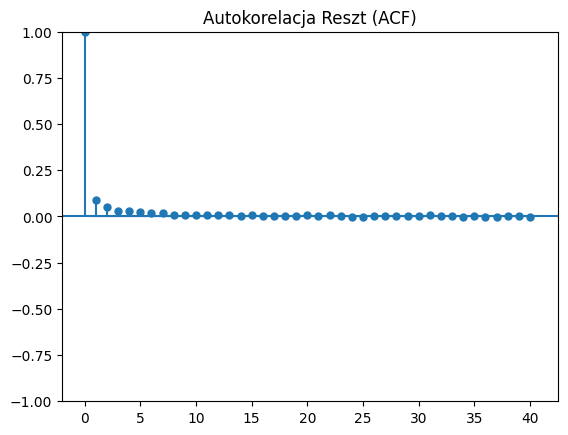

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 16))
plot_acf(residuals_clean.tail(200000), lags=40, fft=True)
plt.title('Autokorelacja Reszt (ACF)')
plt.show()

# Wnioski 15
* Słupki (poza pierwszym) są bardzo niskie, oznacza to, że przyrosty opóźnień między przystankami są od siebie niezależne.
Sugeruje to, że korki w Krakowie mają charakter skokowy (wjazd w zator -> opóźnienie rośnie -> wyjazd -> opóźnienie stabilizuje się na nowym poziomie), ale sam moment złapania kolejnego opóźnienia jest trudny do przewidzenia na podstawie samej historii.

* Wykres pokazuje, że w danych nie ma prostych, liniowych trendów, które można by opisać zwykłą średnią kroczącą.